<a href="https://colab.research.google.com/github/JadeLilyx/IIns-VAE/blob/main/TMS_VSAE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Refining SAE for Correlated Features Extraction

**Motivation**: We have worries that more structured features may be harder to pull apart in the current SAE / dictionary learning setup.

**Project Goal**: Extract correlated features from superposition.


**Concrete Steps**:

*(We put a  ⭐ on each novel point.)*
  + **Toy Model Settings**: Build toy models of bottleneck superposition, inputting features of multiple types of correlation:
      + **Toy model 1**: Original setwise correlation / anti-correlation
      + ⭐ **Toy model 2**: General correlation matrix via Cholesky decomposition
  + **SAE Study** (Baseline Method): Explore the performances of SAEs for disentangling *correlated features*
      + **Basic Cases**: with varying importance and sparsity in generating features.
      + ⭐ **Setwise correlation / anti-correlation**: with `n_correlated_features` and `n_anticorrelated_features` varies in generating features.
      + ⭐ **Correlation matrix**: with correlation matrix varies in generated features.
  + ✨ **VAE Study** (Our Proposal): Explore VAEs and sparsity promoting prior regularizations beyond L1 penalty on activations for disentangling correlated features:
      + ⭐ First, we defines three types of VAEs:
          - **Normal VAE with isotropic Gaussian prior**
            - If `var_flag=0`, it should be equivalent to an SAE.
            - Otherwise, learn a biased dictionary (representation may not be zero-centered).
          - **Advanced VAE with Gaussian mixture prior**
            - For setwise correlation
          - **General VAE with multivariable Gaussian prior**
            - For general correlation
      
      + ⭐ **Basic Cases**: with varying importance and sparsity in generating features.
      + ⭐ **Setwise correlation / anti-correlation**: with `n_correlated_features` and `n_anticorrelated_features` varies in generating features.
      + ⭐ **Correlation matrix**: with correlation matrix varies in generated features.

**Future Work**: Extraction of more structured features and subgraphs / Scaling up in real-world models
  - **Known feature properties** (e.g. associated with certain domain-related labels, or with general importance / sparsity / semantic estimates, etc.): Embed via prior distribution, the resulting objective function will reveal such properties in SAE training.
  - **Unknown feature properties**: Fine-tune via entropy-based regularizations, the resulting objective could choose an estimated factorization of features with lowest entropy (adaptive dictionary).


**Quick Spoil :)**: I think we're having better results from the proposed VAEs in these toy models, for both correlation-related and unrelated cases! ✌


In the following, we mainly do
1. Define toy models of superposition w.r.t. correlated features.

2. Explore SAE performances w.r.t. varying feature properties
  + Build toy AEs for bottleneck superposition, with varying importance, sparsity, and correlation.
  + Build SAEs on the hidden activations of these toy models.
  + Extract features from SAE, and compare these with the toy AE's learnt features.
    - Analyze findings: Performances of SAE with varying feature importance, sparsity, and *correlation (core)*.

3. Explore the variational version of SAE, integrating correlation as prior knowledge
  + Variational SAE: Substitute the loss function to an variational one, see if have different performance.
  + Variation SAE with correlation prior: Embed known correlation-related information as prior, adapt the corresponding new loss function.
    - We build three VAE classes to choose from.


## 0. Setup

In [ ]:
try:
    import google.colab # type: ignore
    IN_COLAB = True
except:
    IN_COLAB = False

if IN_COLAB:
    # Install packages
    %pip install transformer_lens
    %pip install git+https://github.com/callummcdougall/eindex.git

    # Code to download the necessary files
    import os, sys
    from pathlib import Path
    if not os.path.exists("chapter1_transformers"):
        !curl -o /content/main.zip https://codeload.github.com/callummcdougall/sae-exercises-mats/zip/refs/heads/main
        !unzip /content/main.zip
        for f in Path("sae-exercises-mats-main").iterdir():
            f.rename(f.name)
        os.remove("/content/main.zip")
        os.rmdir("sae-exercises-mats-main")

    # Code to make matplotlib figures work (particularly animations)
    from matplotlib import rc
    rc('animation', html='jshtml')
else:
    from IPython import get_ipython
    ipython = get_ipython()
    ipython.run_line_magic("load_ext", "autoreload")
    ipython.run_line_magic("autoreload", "2")
    %matplotlib qt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.0/119.0 kB 2.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 265.7/265.7 kB 8.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 739.7/739.7 kB 13.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 507.1/507.1 kB 10.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.6/44.6 kB 5.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.2/18.2 MB 40.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 670.2/670.2 MB 2.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 89.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 18.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 21.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 69.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 69.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━

In [ ]:
import os
os.environ['KMP_DUPLICATE_LIB_OK'] = 'TRUE'
import torch as t
from torch import nn, Tensor
from torch.distributions.categorical import Categorical
from torch.nn import functional as F
from dataclasses import dataclass
import numpy as np
import einops
from jaxtyping import Float, Int
from typing import Optional, Callable, Union, List, Tuple
from functools import partial
from tqdm.notebook import tqdm
from dataclasses import dataclass
from rich import print as rprint
from IPython.display import display, HTML

from plotly_utils import imshow, line, hist
from plotly_utils_toy_models import (
    plot_features_in_2d,
    plot_features_in_Nd,
    plot_correlated_features,
    plot_feature_geometry,
    frac_active_line_plot
)
import tests as tests
import solutions as solutions

device = t.device("cuda" if t.cuda.is_available() else "cpu")

MAIN = __name__ == "__main__"

## 1. Define models

### 1.1 Define toy model for bottleneck superposition


 **Toy Model Settings**: Build toy models of bottleneck superposition, inputting features of multiple types of correlation:
+ **Toy model 1**: Original setwise correlation / anti-correlation
+ ⭐ **Toy model 2**: General correlation matrix via Cholesky decomposition

#### 1.1.1 Toy model with setwise correlation / anti-correlation features




The formulation of our toy model for bottleneck superposition:
$$h = W x$$
$$x' = ReLU(W^T h + b)$$


In [ ]:
def linear_lr(step, steps):
    return (1 - (step / steps))

def constant_lr(*_):
    return 1.0

def cosine_decay_lr(step, steps):
    return np.cos(0.5 * np.pi * step / (steps - 1))


@dataclass
class Config:
    n_instances: int
    n_features: int = 5
    n_hidden: int = 2
    n_correlated_pairs: int = 0
    n_anticorrelated_pairs: int = 0


class Model(nn.Module):
    W: Float[Tensor, "n_instances n_hidden n_features"]
    b_final: Float[Tensor, "n_instances n_features"]
    # x -> ReLU(W.T @ W @ x + b_final)

    def __init__(
        self,
        cfg: Config,
        feature_probability: Optional[Union[float, Tensor]] = None,
        importance: Optional[Union[float, Tensor]] = None,
        device = device,
    ):
        super().__init__()
        self.cfg = cfg

        if feature_probability is None:
            feature_probability = t.ones(())
        if isinstance(feature_probability, float):
            feature_probability = t.tensor(feature_probability)
        self.feature_probability = feature_probability.to(device).broadcast_to((cfg.n_instances, cfg.n_features))

        if importance is None:
            importance = t.ones(())
        if isinstance(importance, float):
            importance = t.tensor(importance)
        self.importance = importance.to(device).broadcast_to((cfg.n_instances, cfg.n_features))

        self.W = nn.Parameter(nn.init.xavier_normal_(t.empty((cfg.n_instances, cfg.n_hidden, cfg.n_features))))
        self.b_final = nn.Parameter(t.zeros((cfg.n_instances, cfg.n_features)))
        self.to(device)

    def forward(
        self,
        features: Float[Tensor, "... instances features"]
    ) -> Float[Tensor, "... instances features"]:
        hidden = einops.einsum(
            features, self.W,
            "... instances features, instances hidden features -> ... instances hidden"
        )
        out = einops.einsum(
            hidden, self.W,
            "... instances hidden, instances hidden features -> ... instances features"
        )
        return F.relu(out + self.b_final)

    def generate_correlated_features(self, batch_size, n_correlated_pairs) -> Float[Tensor, "batch_size instances features"]:
        '''
        Generates a batch of correlated features.
        Each output[i, j, 2k] and output[i, j, 2k + 1] are correlated, i.e. one is present iff the other is present.
        '''
        feat = t.rand((batch_size, self.cfg.n_instances, 2 * n_correlated_pairs), device=self.W.device)
        feat_set_seeds = t.rand((batch_size, self.cfg.n_instances, n_correlated_pairs), device=self.W.device)
        feat_set_is_present = feat_set_seeds <= self.feature_probability[:, [0]]
        feat_is_present = einops.repeat(feat_set_is_present, "batch instances features -> batch instances (features pair)", pair=2)
        return t.where(feat_is_present, feat, 0.0)

    def generate_anticorrelated_features(self, batch_size, n_anticorrelated_pairs) -> Float[Tensor, "batch_size instances features"]:
        '''
        Generates a batch of anti-correlated features.
        Each output[i, j, 2k] and output[i, j, 2k + 1] are anti-correlated, i.e. one is present iff the other is absent.
        '''
        feat = t.rand((batch_size, self.cfg.n_instances, 2 * n_anticorrelated_pairs), device=self.W.device)
        feat_set_seeds = t.rand((batch_size, self.cfg.n_instances, n_anticorrelated_pairs), device=self.W.device)
        first_feat_seeds = t.rand((batch_size, self.cfg.n_instances, n_anticorrelated_pairs), device=self.W.device)
        feat_set_is_present = feat_set_seeds <= 2 * self.feature_probability[:, [0]]
        first_feat_is_present = first_feat_seeds <= 0.5
        first_feats = t.where(feat_set_is_present & first_feat_is_present, feat[:, :, :n_anticorrelated_pairs], 0.0)
        second_feats = t.where(feat_set_is_present & (~first_feat_is_present), feat[:, :, n_anticorrelated_pairs:], 0.0)
        return einops.rearrange(t.concat([first_feats, second_feats], dim=-1), "batch instances (pair features) -> batch instances (features pair)", pair=2)

    def generate_uncorrelated_features(self, batch_size, n_uncorrelated) -> Float[Tensor, "batch_size instances features"]:
        '''
        Generates a batch of uncorrelated features.
        '''
        feat = t.rand((batch_size, self.cfg.n_instances, n_uncorrelated), device=self.W.device)
        feat_seeds = t.rand((batch_size, self.cfg.n_instances, n_uncorrelated), device=self.W.device)
        feat_is_present = feat_seeds <= self.feature_probability[:, [0]]
        return t.where(feat_is_present, feat, 0.0)

    def generate_batch(self, batch_size) -> Float[Tensor, "batch_size instances features"]:
        '''
        Generates a batch of data, with optional correlated & anticorrelated features.
        '''
        n_uncorrelated = self.cfg.n_features - 2 * self.cfg.n_correlated_pairs - 2 * self.cfg.n_anticorrelated_pairs
        data = []
        if self.cfg.n_correlated_pairs > 0:
            data.append(self.generate_correlated_features(batch_size, self.cfg.n_correlated_pairs))
        if self.cfg.n_anticorrelated_pairs > 0:
            data.append(self.generate_anticorrelated_features(batch_size, self.cfg.n_anticorrelated_pairs))
        if n_uncorrelated > 0:
            data.append(self.generate_uncorrelated_features(batch_size, n_uncorrelated))
        batch = t.cat(data, dim=-1)
        return batch

    def calculate_loss(
        self,
        out: Float[Tensor, "batch instances features"],
        batch: Float[Tensor, "batch instances features"],
    ) -> Float[Tensor, ""]:

        error = self.importance * ((batch - out) ** 2)
        loss = einops.reduce(error, "batch instances features -> instances", 'mean').sum()
        return loss

    def optimize(
        self,
        batch_size: int = 1024,
        steps: int = 10_000,
        log_freq: int = 100,
        lr: float = 1e-3,
        lr_scale: Callable[[int, int], float] = constant_lr,
    ):
        """
        Optimizes the model using the given hyperparameters.
        """
        optimizer = t.optim.Adam(list(self.parameters()), lr=lr)

        progress_bar = tqdm(range(steps))

        for step in progress_bar:

            # Update learning rate
            step_lr = lr * lr_scale(step, steps)
            for group in optimizer.param_groups:
                group['lr'] = step_lr

            # Optimize
            optimizer.zero_grad()
            batch = self.generate_batch(batch_size)
            out = self(batch)
            loss = self.calculate_loss(out, batch)
            loss.backward()
            optimizer.step()

            # Display progress bar
            if step % log_freq == 0 or (step + 1 == steps):
                progress_bar.set_postfix(loss=loss.item()/self.cfg.n_instances, lr=step_lr)


tests.test_model(Model)

All tests in `test_model` passed!


#### 1.1.2 Toy model with Cholesky correlated features

In [ ]:
@dataclass
class ConfigCorr:
    n_instances: int
    n_features: int = 5
    n_hidden: int = 2
    corr_rate: Optional[float] = 0.5
    corr_matrix: Optional[t.Tensor] = None
    # n_correlated_pairs: int = 0
    # n_anticorrelated_pairs: int = 0


class ModelCorr(nn.Module):
    W: Float[Tensor, "n_instances n_hidden n_features"]
    b_final: Float[Tensor, "n_instances n_features"]
    # x -> ReLU(W.T @ W @ x + b_final)

    def __init__(
        self,
        cfg: ConfigCorr,
        feature_probability: Optional[Union[float, Tensor]] = None,
        importance: Optional[Union[float, Tensor]] = None,
        correlation_matrix: Optional[Tensor] = None,
        corr_rate: Optional[float] = 0.5,
        device = device,
    ):
        super().__init__()
        self.cfg = cfg

        if feature_probability is None:
            feature_probability = t.ones(())
        if isinstance(feature_probability, float):
            feature_probability = t.tensor(feature_probability)
        self.feature_probability = feature_probability.to(device).broadcast_to((cfg.n_instances, cfg.n_features))

        if importance is None:
            importance = t.ones(())
        if isinstance(importance, float):
            importance = t.tensor(importance)
        self.importance = importance.to(device).broadcast_to((cfg.n_instances, cfg.n_features))

        # This is new
        if correlation_matrix is None:
            correlation_matrix = t.ones((self.cfg.n_features, self.cfg.n_features)) * cfg.corr_rate
            correlation_matrix.fill_diagonal_(1)
        self.correlation_matrix = correlation_matrix.to(device)

        # Ensure the correlation matrix is valid
        assert t.all(correlation_matrix == correlation_matrix.T)  # Must be symmetric
        assert t.all(t.linalg.eigvalsh(correlation_matrix) > 0)  # Must be positive definite

        self.W = nn.Parameter(nn.init.xavier_normal_(t.empty((cfg.n_instances, cfg.n_hidden, cfg.n_features))))
        self.b_final = nn.Parameter(t.zeros((cfg.n_instances, cfg.n_features)))
        self.to(device)

    def forward(
        self,
        features: Float[Tensor, "... instances features"]
    ) -> Float[Tensor, "... instances features"]:
        hidden = einops.einsum(
            features, self.W,
            "... instances features, instances hidden features -> ... instances hidden"
        )
        out = einops.einsum(
            hidden, self.W,
            "... instances hidden, instances hidden features -> ... instances features"
        )
        return F.relu(out + self.b_final)

    # New data generation
    def generate_batch(
        self,
        batch_size,
        add_noise=False
    ) -> Float[Tensor, "batch_size instances features"]:
        """
        Apply S and C to data generation, and save I in model
        """
        # generate uncorrelated features
        uncorr_feat = t.rand((batch_size, self.cfg.n_instances, self.cfg.n_features), device=self.W.device)

        # transfer to correlated features
        # apply Cholesky decomposition
        device = self.W.device
        L = t.linalg.cholesky(self.correlation_matrix).to(device)
        # transfrom uncorrelated features into correlated
        corr_feat = t.matmul(uncorr_feat, L)

        if add_noise:
            # add noise to ensure not all correlation is perfect
            noise_level = 0.05
            noise = t.normal(0, noise_level, size=corr_feat.shape)
            corr_feat_noisy = corr_feat + noise
            mean = t.mean(corr_feat_noisy, dim=1, keepdim=True)
            std = t.std(corr_feat_noisy, dim=1, keepdim=True)
            std[std == 0] = 1
            corr_feat = (corr_feat_noisy - mean) / std

        corr_feat_seeds = t.rand((batch_size, self.cfg.n_instances, self.cfg.n_features), device=self.W.device)
        corr_feat_is_present = corr_feat_seeds <= self.feature_probability

        batch = t.where(
            corr_feat_is_present,
            corr_feat,
            t.zeros((), device=self.W.device),
        )

        return batch

    def calculate_loss(
        self,
        out: Float[Tensor, "batch instances features"],
        batch: Float[Tensor, "batch instances features"],
    ) -> Float[Tensor, ""]:

        error = self.importance * ((batch - out) ** 2)
        loss = einops.reduce(error, "batch instances features -> instances", 'mean').sum()
        return loss

    def optimize(
        self,
        batch_size: int = 1024,
        steps: int = 10_000,
        log_freq: int = 100,
        lr: float = 1e-3,
        lr_scale: Callable[[int, int], float] = constant_lr,
    ):
        """
        Optimizes the model using the given hyperparameters.
        """
        optimizer = t.optim.Adam(list(self.parameters()), lr=lr)

        progress_bar = tqdm(range(steps))

        for step in progress_bar:

            # Update learning rate
            step_lr = lr * lr_scale(step, steps)
            for group in optimizer.param_groups:
                group['lr'] = step_lr

            # Optimize
            optimizer.zero_grad()
            batch = self.generate_batch(batch_size)
            out = self(batch)
            loss = self.calculate_loss(out, batch)
            loss.backward()
            optimizer.step()

            # Display progress bar
            if step % log_freq == 0 or (step + 1 == steps):
                progress_bar.set_postfix(loss=loss.item()/self.cfg.n_instances, lr=step_lr)


tests.test_model(Model)

All tests in `test_model` passed!


### 1.2 Define SAE for disentanglement (Baseline)



We are going to train our SAE to just take in the hidden state activations $h$, map them to a larger (overcomplete) hidden state $z$, then reconstruct the original hidden state $h$ from $z$.
$$z = ReLU(W_{enc}(h - b_{dec}) + b_{enc})$$
$$h' = W_{dec}z + b_{dec}$$
Note the choice to have a different encoder and decoder weight matrix rather than having them ties.

The loss function for the SAE is:
$$\mathcal{L}(h) = \Vert h - h'\Vert_2^2 + \alpha \Vert z\Vert_1$$

Recapping notation & introducing some new notation:

+ `n_features` = number of features of your model
+ `n_hidden` = number of hidden dimensions of your model
+ `n_input_ae` = number of input dimensions of your SAE. This is the same as `n_hidden`, but we've named it differently to avoid confusion.
+ `n_hidden_ae` = number of hidden dimensions of your SAE.

The shapes of x, x', z, h and h' are summarized as follows (x -> h -> x'; h-> z -> h'),
+ `x` and `x'` are vectors of shape `(n_features,)`
+ `z` is a vector of shape `(n_hidden_ae,)`, which will usually be equal to or larger than `n_features` (overcomplete)
+ `h` and `h'` are vectors of shape `(n_input_ae,)`, also equal to `(n_hidden,)`

In [ ]:
@dataclass
class AutoEncoderConfig:
    n_instances: int
    n_input_ae: int
    n_hidden_ae: int
    l1_coeff: float = 1.0
    tied_weights: bool = False


class AutoEncoder(nn.Module):
    W_enc: Float[Tensor, "n_instances n_input_ae n_hidden_ae"]
    W_dec: Float[Tensor, "n_instances n_hidden_ae n_input_ae"]
    b_enc: Float[Tensor, "n_instances n_hidden_ae"]
    b_dec: Float[Tensor, "n_instances n_input_ae"]

    def __init__(self, cfg: AutoEncoderConfig):
        super().__init__()

        self.cfg = cfg
        self.W_enc = nn.Parameter(nn.init.xavier_normal_(t.empty((cfg.n_instances, cfg.n_input_ae, cfg.n_hidden_ae))))
        if not(cfg.tied_weights):
            self.W_dec = nn.Parameter(nn.init.xavier_normal_(t.empty((cfg.n_instances, cfg.n_hidden_ae, cfg.n_input_ae))))
        self.b_enc = nn.Parameter(t.zeros(cfg.n_instances, cfg.n_hidden_ae))
        self.b_dec = nn.Parameter(t.zeros(cfg.n_instances, cfg.n_input_ae))
        self.to(device)

    def forward(self, h: Float[Tensor, "batch_size n_instances n_hidden"]):

        # Compute activations
        h_cent = h - self.b_dec
        acts = einops.einsum(
            h_cent, self.W_enc,
            "batch_size n_instances n_input_ae, n_instances n_input_ae n_hidden_ae -> batch_size n_instances n_hidden_ae"
        )
        acts = F.relu(acts + self.b_enc)

        # Compute reconstructed input
        h_reconstructed = einops.einsum(
            acts, (self.W_enc.transpose(-1, -2) if self.cfg.tied_weights else self.W_dec),
            "batch_size n_instances n_hidden_ae, n_instances n_hidden_ae n_input_ae -> batch_size n_instances n_input_ae"
        ) + self.b_dec

        # Compute loss, return values
        l2_loss = (h_reconstructed - h).pow(2).sum(-1) # shape [batch_size n_instances]
        l1_loss = acts.abs().sum(-1) # shape [batch_size n_instances]
        loss = (self.cfg.l1_coeff * l1_loss + l2_loss).mean(0).sum() # scalar

        return l1_loss, l2_loss, loss, acts, h_reconstructed

    @t.no_grad()
    def normalize_decoder(self) -> None:
        """
        Normalizes the decoder weights to have unit norm. If using tied weights, we assume W_enc is used for both.
        """
        if self.cfg.tied_weights:
            self.W_enc.data = self.W_enc.data / self.W_enc.data.norm(dim=1, keepdim=True)
        else:
            self.W_dec.data = self.W_dec.data / self.W_dec.data.norm(dim=1, keepdim=True)

    @t.no_grad()
    def resample_neurons(
        self,
        h: Float[Tensor, "batch_size n_instances n_hidden"],
        frac_active_in_window: Float[Tensor, "window n_instances n_hidden_ae"],
        neuron_resample_scale: float,
    ) -> None:
        """
        Resamples neurons that have been dead for 'dead_neuron_window' steps, according to 'frac_active'.
        """
        _, l2_loss, _, _, _ = self.forward(h)

        # Create an object to store the dead neurons (this will be useful for plotting)
        dead_neurons_mask = t.empty((self.cfg.n_instances, self.cfg.n_hidden_ae), dtype=t.bool, device=self.W_enc.device)

        for instance in range(self.cfg.n_instances):

            # Find the dead neurons in this instance. If all neurons are alive, continue
            is_dead = (frac_active_in_window[:, instance].sum(0) < 1e-8)
            dead_neurons_mask[instance] = is_dead
            dead_neurons = t.nonzero(is_dead).squeeze(-1)
            alive_neurons = t.nonzero(~is_dead).squeeze(-1)
            n_dead = dead_neurons.numel()
            if n_dead == 0:
              continue

            # Compute L2 loss for each element in the batch
            l2_loss_instance = l2_loss[:, instance]  # [batch_size]
            if l2_loss_instance.max() < 1e-6:
                continue  # If we have zero reconstruction loss, we don't need to resample neurons

            # Draw 'n_hidden_ae' samples from [0, 1, ..., batch_size-1], with probabilities proportional to l2_loss
            distn = Categorical(probs = l2_loss_instance / l2_loss_instance.sum())
            replacement_indices = distn.sample((n_dead,))  # shape [n_dead]

            # Index into the batch of hidden activations to get our replacement values
            replacement_values = (h - self.b_dec)[replacement_indices, instance]  # shape [n_dead n_input_ae]

            # Get the norm of alive neurons (or 1.0 if there are no alive neurons)
            W_enc_norm_alive_mean = 1.0 if len(alive_neurons) == 0 else self.W_enc[instance, :, alive_neurons].norm(dim=0).mean().item()

            # Use this to renormalize the replacement values
            replacement_values = (replacement_values / (replacement_values.norm(dim=1, keepdim=True) + 1e-8)) * W_enc_norm_alive_mean * neuron_resample_scale

            # Lastly, set the new weights & bias
            self.W_enc.data[instance, :, dead_neurons] = replacement_values.T
            self.b_enc.data[instance, dead_neurons] = 0.0

        # Return data for visualizing the resampling process
        colors = [["red" if dead else "black" for dead in dead_neuron_mask_inst] for dead_neuron_mask_inst in dead_neurons_mask]
        title = f"resampling {dead_neurons_mask.sum()}/{dead_neurons_mask.numel()} neurons (shown in red)"
        return colors, title

    def optimize(
        self,
        model: Model,
        batch_size: int = 1024,
        steps: int = 10_000,
        log_freq: int = 100,
        lr: float = 1e-3,
        lr_scale: Callable[[int, int], float] = constant_lr,
        neuron_resample_window: Optional[int] = None,
        dead_neuron_window: Optional[int] = None,
        neuron_resample_scale: float = 0.2,
    ):
        """
        Optimizes the SAE using the given hyperparameters.

        This function should take a trained model as input.
        """
        if neuron_resample_window is not None:
            assert (dead_neuron_window is not None) and (dead_neuron_window < neuron_resample_window)

        optimizer = t.optim.Adam(list(self.parameters()), lr=lr)
        frac_active_list = []
        progress_bar = tqdm(range(steps))

        # Create lists to store data we'll eventually be plotting
        data_log = {"values": [], "colors": [], "titles": [], "frac_active": []}
        colors = None
        title = "no resampling yet"

        for step in progress_bar:

            # Normalize the decoder weights before each optimization step
            self.normalize_decoder()

            # Resample dead neurons
            if (neuron_resample_window  is not None) and ((step + 1) % neuron_resample_window == 0):
                # Get the fraction of neurons active in the previous window
                frac_active_in_window = t.stack(frac_active_list[-neuron_resample_window:], dim=0)
                # Compute batch of hidden activations which we'll use in resampling
                batch = model.generate_batch(batch_size)
                h = einops.einsum(batch, model.W, "batch_size instances features, instances hidden features -> batch_size instances hidden")
                # Resample
                colors, title = self.resample_neurons(h, frac_active_in_window, neuron_resample_scale)

            # Update learning rate
            step_lr = lr * lr_scale(step, steps)
            for group in optimizer.param_groups:
                group['lr'] = step_lr

            # Get a batch of hidden activations from the model
            with t.inference_mode():
                features = model.generate_batch(batch_size)
                h = einops.einsum(features, model.W, "... instances features, instances hidden features -> ... instances hidden")

            # Optimize
            optimizer.zero_grad()
            l1_loss, l2_loss, loss, acts, _ = self.forward(h)
            loss.backward()
            optimizer.step()

            # Calculate the sparsities, and add it to a list
            frac_active = einops.reduce((acts.abs() > 1e-8).float(), "batch_size instances hidden_ae -> instances hidden_ae", "mean")
            frac_active_list.append(frac_active)

            # Display progress bar, and append new values for plotting
            if step % log_freq == 0 or (step + 1 == steps):
                progress_bar.set_postfix(l1_loss=l1_loss.mean(0).sum().item(), l2_loss=l2_loss.mean(0).sum().item(), lr=step_lr)
                data_log["values"].append(self.W_enc.detach().cpu())
                data_log["colors"].append(colors)
                data_log["titles"].append(f"Step {step}/{steps}: {title}")
                data_log["frac_active"].append(frac_active.detach().cpu())

        return data_log

### 1.3 Define VAEs for disentanglement with prior knowledge (Proposal)



✨ We have 3 types of VAEs at your service:
+ ⭐ 1.3.1 Standard VAE with isotropic Gaussian pior
  - **Prior Assumption**: The latent space follows a standard multivariate Gaussian distribution with an isotropic (diagonal) covariance matrix. This is the most common and simplest form of VAE.
  - **Use Case**: Best suited for scenarios where there is no specific assumption about correlations or relationships between latent variables. It's the default choice for many applications.
  - *We expect it to have similar performance as SAE in superposition learning.*
+ ⭐ 1.3.2 Advanced VAE with Gaussian mixture prior (Summation of isotropic Gaussians)
  - **Prior Assumption**: The latent space is modeled as a *sum* of independent isotropic Gaussian distributions, each representing a pair of correlated or anticorrelated features.
  - **Use Case**: Useful when the data has distinct sets of features that are known to be correlated or anticorrelated. This model tries to capture these pairwise relationships in the latent space. It's a more structured approach than the standard VAE but less complex than a full covariance model.
  - *We expect it to have better performance as SAE, especially for cases with correlated or anticorrelated pairs of features.*
+ ⭐ 1.3.3 General VAE with multivariate Gaussian prior (Cholesky decomposition)
  - **Prior Assumption**: The latent space follows a multivariate Gaussian distribution with a full covariance matrix, which can capture complex relationships, including correlations and anticorrelations between any pair of latent variables. The covariance matrix is often parameterized using its Cholesky decomposition to ensure positive definiteness.
  - **Use Case**: Appropriate for scenarios where the relationships between latent variables are complex and not limited to pairwise correlations. This model is the most flexible and can capture a wide range of dependencies in the latent space, but it's also the most computationally intensive and complex to implement.
  - * We expect it to have the best performance, especially for cases with complicated feature correlations.*

#### 1.3.1 Standard VAE with isotropic Gaussian prior (should be similar as SAE in performance)



Similar to the above, our VAE take in the hidden state activations $h$, map them to a larger (overcomplete) hidden state $z$, then reconstruct the original hidden state $h$ from $z$. However in this case, the VAE defines a distribution over the latent space. The latent space is characterized by two sets of parameters: means ($\mu$) and log variances (\log(\sigma^2)), which are derived from $h$ through learned transformations.

The encoding process involves transforming the input hidden state activations $h$ into parameters of the latent space distribution.
+ The mean $\mu$ is computed as:
$$\mu = ReLU(W_{enc}(h-b_{dec})+b_{enc})$$
+ The log variance $\log(\sigma^2)$ is computed similarly, using separate parameters $W_{enc\_var}$ and $b_{enc\_var}$.
$$\log(\sigma^2) = ReLU(W_{enc\_var}(h - b_{dec}) + b_{enc\_var})$$

+ Via the reparameterization trick for BP, a sample $z$ from the latent space is generated as:
$$z = \mu + \sigma \circ * ϵ$$
+ The reconstructed hidden state $h'$ is computed as:
$$h' = W_{dec}z + b_{dec}$$

The loss function for the VSAE is:
$$\mathcal{L}(h) = \Vert h - h'\Vert_2^2 + \alpha *\mathcal{L}_{KL}(z)$$
where
$$p(z)=\mathcal{N}(z; 0, I)$$
$$\mathcal{L}_{KL}(z)=-\frac{1}{2}\sum_{i=1}^D(1+\log(\sigma_i^2)-\mu_i^2 - \sigma_i^2)$$

*Conditional Behavior Based on `var_flag`*:
+ The VAE includes a conditional behavior controlled by `var_flag`
+ When `var_flag` is 0, the variance $\log(\sigma^2)$ is fixed, and the model behaves **similarly to an SAE** with a normal distribution as the prior. *(We should have similar performances of such VAE to the original SAE)*
+ When `var_flag` is 1, the VAE learns both $\mu$ and $\log(\sigma^2)$ (the prior is Gaussian). *(Compare if such VAE can result in a performance improvement)*

**Summary**

The VAE extends the SAE by introducing a probabilistic latent space. The use of the reparameterization trick and the KL divergence term are key differences from the SAE, *making the VAE capable of including prior knowledge of the latent representation*. The conditional `var_flag` adds flexibility, allowing the model to switch between a full probabilistic representation and using a fixed variance akin to a standard AE.



In [ ]:
@dataclass
class VariationalAutoEncoderConfig:
    n_instances: int
    n_input_ae: int
    n_hidden_ae: int
    kl_coeff: float = 1.0  # l1_coeff
    tied_weights: bool = False


class VariationalAutoEncoder(nn.Module):
    W_enc: Float[Tensor, "n_instances n_input_ae n_hidden_ae"]
    W_enc_var: Float[Tensor, "n_instances n_input_ae n_hidden_ae"]
    W_dec: Float[Tensor, "n_instances n_hidden_ae n_input_ae"]
    b_enc: Float[Tensor, "n_instances n_hidden_ae"]
    b_enc_var: Float[Tensor, "n_instances n_hidden_ae"]
    b_dec: Float[Tensor, "n_instances n_input_ae"]

    def __init__(self, cfg: VariationalAutoEncoderConfig, var_flag=0):
        super().__init__()
        self.cfg = cfg
        self.var_flag = var_flag

        self.W_enc = nn.Parameter(nn.init.xavier_normal_(t.empty((cfg.n_instances, cfg.n_input_ae, cfg.n_hidden_ae))))
        if not(cfg.tied_weights):
            self.W_dec = nn.Parameter(nn.init.xavier_normal_(t.empty((cfg.n_instances, cfg.n_hidden_ae, cfg.n_input_ae))))
        self.b_enc = nn.Parameter(t.zeros(cfg.n_instances, cfg.n_hidden_ae))
        self.b_dec = nn.Parameter(t.zeros(cfg.n_instances, cfg.n_input_ae))

        # Additional parameters for VAE variance
        if self.var_flag == 1:
            # Initialize parameters for variance when var_flag is 1, o.w. use fixed variance
            self.W_enc_var = nn.Parameter(nn.init.xavier_normal_(t.empty((cfg.n_instances, cfg.n_input_ae, cfg.n_hidden_ae))))
            if not(cfg.tied_weights):
                self.W_dec_var = nn.Parameter(nn.init.xavier_normal_(t.empty((cfg.n_instances, cfg.n_hidden_ae, cfg.n_input_ae))))
            self.b_enc_var = nn.Parameter(t.zeros(cfg.n_instances, cfg.n_hidden_ae))
            self.b_dec_var = nn.Parameter(t.zeros(cfg.n_instances, cfg.n_input_ae))

        self.to(device)

    def forward(self, h: Float[Tensor, "batch_size n_instances n_hidden"]):

        # Compute activations
        h_cent = h - self.b_dec
        acts = einops.einsum(
            h_cent, self.W_enc,
            "batch_size n_instances n_input_ae, n_instances n_input_ae n_hidden_ae -> batch_size n_instances n_hidden_ae"
        )
        acts = F.relu(acts + self.b_enc)

        # Compute activation variances
        if self.var_flag == 1:
            h_cent_var = h - self.b_dec_var
            acts_var = einops.einsum(
                h_cent_var, self.W_enc_var,
                "batch_size n_instances n_input_ae, n_instances n_input_ae n_hidden_ae -> batch_size n_instances n_hidden_ae"
            )
            acts_log_var = F.relu(acts_var + self.b_enc_var)
        else:
            acts_log_var = t.zeros_like(acts)

        # Sample from the latent distribution
        z = self.reparameterize(acts, acts_log_var)

        # Compute reconstructed input
        h_reconstructed = einops.einsum(
            acts, (self.W_enc.transpose(-1, -2) if self.cfg.tied_weights else self.W_dec),
            "batch_size n_instances n_hidden_ae, n_instances n_hidden_ae n_input_ae -> batch_size n_instances n_input_ae"
        ) + self.b_dec

        # Compute loss, return values
        l2_loss = (h_reconstructed - h).pow(2).sum(-1) # shape [batch_size n_instances]
        # l1_loss = acts.abs().sum(-1) # shape [batch_size n_instances]
        kl_loss = -0.5 * t.sum(1 + acts_log_var - acts.pow(2) - acts_log_var.exp(), dim=1)  # shape [batch_size n_instances]
        loss = self.cfg.kl_coeff * kl_loss.mean() + l2_loss.mean(0).sum() # scalar

        return kl_loss, l2_loss, loss, acts, h_reconstructed

    def reparameterize(self, mu, log_var):
        std = t.exp(0.5 * log_var)
        eps = t.randn_like(std)
        return mu + eps * std

    @t.no_grad()
    def normalize_decoder(self) -> None:
        '''
        Normalizes the decoder weights to have unit norm. If using tied weights, we we assume W_enc is used for both.
        '''
        if self.cfg.tied_weights:
            self.W_enc.data = self.W_enc.data / self.W_enc.data.norm(dim=1, keepdim=True)
        else:
            self.W_dec.data = self.W_dec.data / self.W_dec.data.norm(dim=2, keepdim=True)

    @t.no_grad()
    def resample_neurons(
        self,
        h: Float[Tensor, "batch_size n_instances n_hidden"],
        frac_active_in_window: Float[Tensor, "window n_instances n_hidden_ae"],
        neuron_resample_scale: float,
    ) -> None:
        '''
        Resamples neurons that have been dead for `dead_neuron_window` steps, according to `frac_active`.
        '''
        _, l2_loss, _, _, _ = self.forward(h)

        # Create an object to store the dead neurons (this will be useful for plotting)
        dead_neurons_mask = t.empty((self.cfg.n_instances, self.cfg.n_hidden_ae), dtype=t.bool, device=self.W_enc.device)

        for instance in range(self.cfg.n_instances):

            # Find the dead neurons in this instance. If all neurons are alive, continue
            is_dead = (frac_active_in_window[:, instance].sum(0) < 1e-8)
            dead_neurons_mask[instance] = is_dead
            dead_neurons = t.nonzero(is_dead).squeeze(-1)
            alive_neurons = t.nonzero(~is_dead).squeeze(-1)
            n_dead = dead_neurons.numel()
            if n_dead == 0: continue

            # Compute L2 loss for each element in the batch
            l2_loss_instance = l2_loss[:, instance] # [batch_size]
            if l2_loss_instance.max() < 1e-6:
                continue # If we have zero reconstruction loss, we don't need to resample neurons

            # Draw `n_hidden_ae` samples from [0, 1, ..., batch_size-1], with probabilities proportional to l2_loss
            distn = Categorical(probs = l2_loss_instance / l2_loss_instance.sum())
            replacement_indices = distn.sample((n_dead,)) # shape [n_dead]

            # Index into the batch of hidden activations to get our replacement values
            replacement_values = (h - self.b_dec)[replacement_indices, instance] # shape [n_dead n_input_ae]

            # Get the norm of alive neurons (or 1.0 if there are no alive neurons)
            W_enc_norm_alive_mean = 1.0 if len(alive_neurons) == 0 else self.W_enc[instance, :, alive_neurons].norm(dim=0).mean().item()

            # Use this to renormalize the replacement values
            replacement_values = (replacement_values / (replacement_values.norm(dim=1, keepdim=True) + 1e-8)) * W_enc_norm_alive_mean * neuron_resample_scale

            # Lastly, set the new weights & biases
            self.W_enc.data[instance, :, dead_neurons] = replacement_values.T
            self.b_enc.data[instance, dead_neurons] = 0.0

        # Return data for visualising the resampling process
        colors = [["red" if dead else "black" for dead in dead_neuron_mask_inst] for dead_neuron_mask_inst in dead_neurons_mask]
        title = f"resampling {dead_neurons_mask.sum()}/{dead_neurons_mask.numel()} neurons (shown in red)"
        return colors, title

    def optimize(
        self,
        model: Model,
        batch_size: int = 1024,
        steps: int = 10_000,
        log_freq: int = 100,
        lr: float = 1e-3,
        lr_scale: Callable[[int, int], float] = constant_lr,
        neuron_resample_window: Optional[int] = None,
        dead_neuron_window: Optional[int] = None,
        neuron_resample_scale: float = 0.2,
    ):
        '''
        Optimizes the autoencoder using the given hyperparameters.

        This function should take a trained model as input.
        '''
        if neuron_resample_window is not None:
            assert (dead_neuron_window is not None) and (dead_neuron_window < neuron_resample_window)

        optimizer = t.optim.Adam(list(self.parameters()), lr=lr)
        frac_active_list = []
        progress_bar = tqdm(range(steps))

        # Create lists to store data we'll eventually be plotting
        data_log = {"values": [], "colors": [], "titles": [], "frac_active": []}
        colors = None
        title = "no resampling yet"

        for step in progress_bar:

            # Normalize the decoder weights before each optimization step
            self.normalize_decoder()

            # Resample dead neurons
            if (neuron_resample_window is not None) and ((step + 1) % neuron_resample_window == 0):
                # Get the fraction of neurons active in the previous window
                frac_active_in_window = t.stack(frac_active_list[-neuron_resample_window:], dim=0)
                # Compute batch of hidden activations which we'll use in resampling
                batch = model.generate_batch(batch_size)
                h = einops.einsum(batch, model.W, "batch_size instances features, instances hidden features -> batch_size instances hidden")
                # Resample
                colors, title = self.resample_neurons(h, frac_active_in_window, neuron_resample_scale)

            # Update learning rate
            step_lr = lr * lr_scale(step, steps)
            for group in optimizer.param_groups:
                group['lr'] = step_lr

            # Get a batch of hidden activations from the model
            with t.inference_mode():
                features = model.generate_batch(batch_size)
                h = einops.einsum(features, model.W, "... instances features, instances hidden features -> ... instances hidden")

            # Optimize
            optimizer.zero_grad()
            l1_loss, l2_loss, loss, acts, _ = self.forward(h)
            loss.backward()
            optimizer.step()

            # Calculate the sparsities, and add it to a list
            frac_active = einops.reduce((acts.abs() > 1e-8).float(), "batch_size instances hidden_ae -> instances hidden_ae", "mean")
            frac_active_list.append(frac_active)

            # Display progress bar, and append new values for plotting
            if step % log_freq == 0 or (step + 1 == steps):
                progress_bar.set_postfix(l1_loss=l1_loss.mean(0).sum().item(), l2_loss=l2_loss.mean(0).sum().item(), lr=step_lr)
                data_log["values"].append(self.W_enc.detach().cpu())
                data_log["colors"].append(colors)
                data_log["titles"].append(f"Step {step}/{steps}: {title}")
                data_log["frac_active"].append(frac_active.detach().cpu())

        return data_log

#### 1.3.2 Advanced VAE with Gaussian mixture prior (to disentangle correlated / anti-correlated feature pairs)


The Advanced VAE extends the standard VAE by introducing a more structured prior distribution in the latent space. This model is specifically designed to handle datasets with known correlations or anticorrelations between certain feature pairs. It achieves this by using a sum of isotropic Gaussian distributions as priors, where each Gaussian represents a pair of correlated or anticorrelated features.

The encoding and decoding processes are all the same:
$$\mu = ReLU(W_{enc}(h-b_{dec})+b_{enc})$$
$$\log(\sigma^2) = ReLU(W_{enc\_var}(h - b_{dec}) + b_{enc\_var})$$

$$z = \mu + \sigma \circ * ϵ$$

$$h' = W_{dec}z + b_{dec}$$

The key difference lies in its structured prior distribution, revealed in the loss function:
$$\mathcal{L}(h) = \Vert h - h'\Vert_2^2 + \alpha *\mathcal{L}_{KL，Mix}(z)$$
where
$$p(z)=\sum_i \mathcal{N}(z_i; \mu_{prior,i}, \sigma_{prior,i}^2I)$$
$$\mathcal{L}_{KL, Mix}(z)=\sum_{i=1}^D\mathcal{L}_{KL, Mix}(z_i)=-\frac{1}{2}\sum_{i=1}^D(1+\log(\frac{\sigma_i^2}{\sigma_{prior,i}^2})-\frac{(\mu_i-\mu_{prior,i})^2 + \sigma_i^2}{\sigma_{prior,i}^2})$$

In [ ]:
@dataclass
class MixVariationalAutoEncoderConfig:
    n_instances: int
    n_input_ae: int
    n_hidden_ae: int
    kl_coeff: float = 1.0  # l1_coeff
    tied_weights: bool = False
    # This is new
    n_correlated_pairs: int = 0
    n_anticorrelated_pairs: int = 0


class MixVariationalAutoEncoder(nn.Module):
    W_enc: Float[Tensor, "n_instances n_input_ae n_hidden_ae"]
    W_enc_var: Float[Tensor, "n_instances n_input_ae n_hidden_ae"]
    W_dec: Float[Tensor, "n_instances n_hidden_ae n_input_ae"]
    b_enc: Float[Tensor, "n_instances n_hidden_ae"]
    b_enc_var: Float[Tensor, "n_instances n_hidden_ae"]
    b_dec: Float[Tensor, "n_instances n_input_ae"]

    def __init__(self, cfg: MixVariationalAutoEncoderConfig, var_flag=0):
        super().__init__()
        self.cfg = cfg
        self.var_flag = var_flag

        self.W_enc = nn.Parameter(nn.init.xavier_normal_(t.empty((cfg.n_instances, cfg.n_input_ae, cfg.n_hidden_ae))))
        if not(cfg.tied_weights):
            self.W_dec = nn.Parameter(nn.init.xavier_normal_(t.empty((cfg.n_instances, cfg.n_hidden_ae, cfg.n_input_ae))))
        self.b_enc = nn.Parameter(t.zeros(cfg.n_instances, cfg.n_hidden_ae))
        self.b_dec = nn.Parameter(t.zeros(cfg.n_instances, cfg.n_input_ae))

        # Additional parameters for VAE variance
        if self.var_flag == 1:
            # Initialize parameters for variance when var_flag is 1, o.w. use fixed variance
            self.W_enc_var = nn.Parameter(nn.init.xavier_normal_(t.empty((cfg.n_instances, cfg.n_input_ae, cfg.n_hidden_ae))))
            self.b_enc_var = nn.Parameter(t.zeros(cfg.n_instances, cfg.n_hidden_ae))

        self.to(device)

        # Initialize the prior means for correlated and anticorrelated features
        self.prior_means = self.initialize_prior_means(cfg)

    def initialize_prior_means(self, cfg):
        means = []

        # Correlated pairs: similar means
        for _ in range(cfg.n_correlated_pairs):
            means.extend([1.0, 1.0])

        # Anticorrelated pairs: opposite means
        for _ in range(cfg.n_anticorrelated_pairs):
            means.extend([1.0, -1.0])

        # Remaining features: zero mean
        remaining_features = cfg.n_hidden_ae - 2 * (cfg.n_correlated_pairs + cfg.n_anticorrelated_pairs)
        means.extend([0.0] * remaining_features)

        return t.tensor(means, dtype=t.float32, device=self.W_enc.device)

    def forward(self, h: Float[Tensor, "batch_size n_instances n_hidden"]):

        # Compute activations
        h_cent = h - self.b_dec
        acts = einops.einsum(
            h_cent, self.W_enc,
            "batch_size n_instances n_input_ae, n_instances n_input_ae n_hidden_ae -> batch_size n_instances n_hidden_ae"
        )
        acts = F.relu(acts + self.b_enc)

        # Compute activation variances
        if self.var_flag == 1:
            h_cent_var = h - self.b_dec_var
            acts_var = einops.einsum(
                h_cent_var, self.W_enc_var,
                "batch_size n_instances n_input_ae, n_instances n_input_ae n_hidden_ae -> batch_size n_instances n_hidden_ae"
            )
            acts_log_var = F.relu(acts_var + self.b_enc_var)
        else:
            acts_log_var = t.zeros_like(acts)

        # Sample from the latent distribution
        z = self.reparameterize(acts, acts_log_var)

        # Compute reconstructed input
        h_reconstructed = einops.einsum(
            acts, (self.W_enc.transpose(-1, -2) if self.cfg.tied_weights else self.W_dec),
            "batch_size n_instances n_hidden_ae, n_instances n_hidden_ae n_input_ae -> batch_size n_instances n_input_ae"
        ) + self.b_dec

        # Compute loss, return values
        l2_loss = (h_reconstructed - h).pow(2).sum(-1) # shape [batch_size n_instances]
        # l1_loss = acts.abs().sum(-1) # shape [batch_size n_instances]
        # kl_loss = -0.5 * t.sum(1 + acts_log_var - acts.pow(2) - acts_log_var.exp(), dim=1)  # shape [batch_size n_instances]
        kl_loss = self.compute_kl_divergence(acts, acts_log_var)
        loss = self.cfg.kl_coeff * kl_loss + l2_loss.mean(0).sum() # scalar

        return kl_loss, l2_loss, loss, acts, h_reconstructed

    def compute_kl_divergence(self, mu, log_var):
        # Assuming a diagonal covariance matrix for the approximate posterior
        sigma_squared = t.exp(log_var)

        kl_div = 0.5 * ((mu - self.prior_means) ** 2 + sigma_squared - 1 - log_var).sum(dim=1)

        return kl_div.mean()

    def reparameterize(self, mu, log_var):
        std = t.exp(0.5 * log_var)
        eps = t.randn_like(std)
        return mu + eps * std

    @t.no_grad()
    def normalize_decoder(self) -> None:
        '''
        Normalizes the decoder weights to have unit norm. If using tied weights, we we assume W_enc is used for both.
        '''
        if self.cfg.tied_weights:
            self.W_enc.data = self.W_enc.data / self.W_enc.data.norm(dim=1, keepdim=True)
        else:
            self.W_dec.data = self.W_dec.data / self.W_dec.data.norm(dim=2, keepdim=True)

    @t.no_grad()
    def resample_neurons(
        self,
        h: Float[Tensor, "batch_size n_instances n_hidden"],
        frac_active_in_window: Float[Tensor, "window n_instances n_hidden_ae"],
        neuron_resample_scale: float,
    ) -> None:
        '''
        Resamples neurons that have been dead for `dead_neuron_window` steps, according to `frac_active`.
        '''
        _, l2_loss, _, _, _ = self.forward(h)

        # Create an object to store the dead neurons (this will be useful for plotting)
        dead_neurons_mask = t.empty((self.cfg.n_instances, self.cfg.n_hidden_ae), dtype=t.bool, device=self.W_enc.device)

        for instance in range(self.cfg.n_instances):

            # Find the dead neurons in this instance. If all neurons are alive, continue
            is_dead = (frac_active_in_window[:, instance].sum(0) < 1e-8)
            dead_neurons_mask[instance] = is_dead
            dead_neurons = t.nonzero(is_dead).squeeze(-1)
            alive_neurons = t.nonzero(~is_dead).squeeze(-1)
            n_dead = dead_neurons.numel()
            if n_dead == 0: continue

            # Compute L2 loss for each element in the batch
            l2_loss_instance = l2_loss[:, instance] # [batch_size]
            if l2_loss_instance.max() < 1e-6:
                continue # If we have zero reconstruction loss, we don't need to resample neurons

            # Draw `n_hidden_ae` samples from [0, 1, ..., batch_size-1], with probabilities proportional to l2_loss
            distn = Categorical(probs = l2_loss_instance / l2_loss_instance.sum())
            replacement_indices = distn.sample((n_dead,)) # shape [n_dead]

            # Index into the batch of hidden activations to get our replacement values
            replacement_values = (h - self.b_dec)[replacement_indices, instance] # shape [n_dead n_input_ae]

            # Get the norm of alive neurons (or 1.0 if there are no alive neurons)
            W_enc_norm_alive_mean = 1.0 if len(alive_neurons) == 0 else self.W_enc[instance, :, alive_neurons].norm(dim=0).mean().item()

            # Use this to renormalize the replacement values
            replacement_values = (replacement_values / (replacement_values.norm(dim=1, keepdim=True) + 1e-8)) * W_enc_norm_alive_mean * neuron_resample_scale

            # Lastly, set the new weights & biases
            self.W_enc.data[instance, :, dead_neurons] = replacement_values.T
            self.b_enc.data[instance, dead_neurons] = 0.0

        # Return data for visualising the resampling process
        colors = [["red" if dead else "black" for dead in dead_neuron_mask_inst] for dead_neuron_mask_inst in dead_neurons_mask]
        title = f"resampling {dead_neurons_mask.sum()}/{dead_neurons_mask.numel()} neurons (shown in red)"
        return colors, title

    def optimize(
        self,
        model: Model,
        batch_size: int = 1024,
        steps: int = 10_000,
        log_freq: int = 100,
        lr: float = 1e-3,
        lr_scale: Callable[[int, int], float] = constant_lr,
        neuron_resample_window: Optional[int] = None,
        dead_neuron_window: Optional[int] = None,
        neuron_resample_scale: float = 0.2,
    ):
        '''
        Optimizes the autoencoder using the given hyperparameters.

        This function should take a trained model as input.
        '''
        if neuron_resample_window is not None:
            assert (dead_neuron_window is not None) and (dead_neuron_window < neuron_resample_window)

        optimizer = t.optim.Adam(list(self.parameters()), lr=lr)
        frac_active_list = []
        progress_bar = tqdm(range(steps))

        # Create lists to store data we'll eventually be plotting
        data_log = {"values": [], "colors": [], "titles": [], "frac_active": []}
        colors = None
        title = "no resampling yet"

        for step in progress_bar:

            # Normalize the decoder weights before each optimization step
            self.normalize_decoder()

            # Resample dead neurons
            if (neuron_resample_window is not None) and ((step + 1) % neuron_resample_window == 0):
                # Get the fraction of neurons active in the previous window
                frac_active_in_window = t.stack(frac_active_list[-neuron_resample_window:], dim=0)
                # Compute batch of hidden activations which we'll use in resampling
                batch = model.generate_batch(batch_size)
                h = einops.einsum(batch, model.W, "batch_size instances features, instances hidden features -> batch_size instances hidden")
                # Resample
                colors, title = self.resample_neurons(h, frac_active_in_window, neuron_resample_scale)

            # Update learning rate
            step_lr = lr * lr_scale(step, steps)
            for group in optimizer.param_groups:
                group['lr'] = step_lr

            # Get a batch of hidden activations from the model
            with t.inference_mode():
                features = model.generate_batch(batch_size)
                h = einops.einsum(features, model.W, "... instances features, instances hidden features -> ... instances hidden")

            # Optimize
            optimizer.zero_grad()
            l1_loss, l2_loss, loss, acts, _ = self.forward(h)
            loss.backward()
            optimizer.step()

            # Calculate the sparsities, and add it to a list
            frac_active = einops.reduce((acts.abs() > 1e-8).float(), "batch_size instances hidden_ae -> instances hidden_ae", "mean")
            frac_active_list.append(frac_active)

            # Display progress bar, and append new values for plotting
            if step % log_freq == 0 or (step + 1 == steps):
                progress_bar.set_postfix(l1_loss=l1_loss.mean(0).sum().item(), l2_loss=l2_loss.mean(0).sum().item(), lr=step_lr)
                data_log["values"].append(self.W_enc.detach().cpu())
                data_log["colors"].append(colors)
                data_log["titles"].append(f"Step {step}/{steps}: {title}")
                data_log["frac_active"].append(frac_active.detach().cpu())

        return data_log

#### 1.3.3 General VAE with multivariate Gaussian prior (to disentangle Cholesky correlation)


The General VAE represents an advanced adaptation of the standard VAE, designed to handle complex relationships within the data. It is characterized by its use of a multivariate Gaussian distribution with a full covariance matrix as the prior in the latent space. This approach allows the model to capture intricate correlations and dependencies between latent variables, going beyond simple pairwise correlations.

The encoding and decoding processes are all the same:
$$\mu = ReLU(W_{enc}(h-b_{dec})+b_{enc})$$
$$\log(\sigma^2) = ReLU(W_{enc\_var}(h - b_{dec}) + b_{enc\_var})$$

$$z = \mu + \sigma \circ * ϵ$$

$$h' = W_{dec}z + b_{dec}$$

The key difference lies in its structured prior distribution, revealed in the loss function:
$$\mathcal{L}(h) = \Vert h - h'\Vert_2^2 + \alpha *\mathcal{L}_{KL，Multi}(z)$$
where
$$p(z)=\mathcal{N}(z; \mu_p, \Sigma_p)$$
$$\mathcal{L}_{KL, Multi}(z)=\frac{1}{2}\big(tr(\Sigma_p^{-1}\Sigma_q)+(\mu - \mu_p)^T\Sigma_p^{-1}(\mu - \mu_p) - k + \log(\frac{det(\Sigma_p)}{det(\Sigma_q)}))\big)$$

**Key Differences**

+ **Case 2 (Summation of isotropic Gaussians)**: The KL divergence is computed for each feature independently, assuming an isotropic Gaussian prior for each. This is simpler and assumes independence or specific pairwise correlations.

+ **Case 3 (Multivariate Gaussian prior)**: The KL divergence accounts for the full covariance structure of the prior, allowing for complex inter-feature dependencies. This is more computationally intensive but captures a richer set of relationships.


In [ ]:
@dataclass
class GeneralVariationalAutoEncoderConfig:
    n_instances: int
    n_input_ae: int
    n_hidden_ae: int
    kl_coeff: float = 1.0  # l1_coeff
    tied_weights: bool = False
    # This is new
    corr_rate: Optional[float] = 0.5
    corr_matrix: Optional[Tensor] = None


class GeneralVariationalAutoEncoder(nn.Module):
    W_enc: Float[Tensor, "n_instances n_input_ae n_hidden_ae"]
    W_enc_var: Float[Tensor, "n_instances n_input_ae n_hidden_ae"]
    W_dec: Float[Tensor, "n_instances n_hidden_ae n_input_ae"]
    b_enc: Float[Tensor, "n_instances n_hidden_ae"]
    b_enc_var: Float[Tensor, "n_instances n_hidden_ae"]
    b_dec: Float[Tensor, "n_instances n_input_ae"]

    def __init__(self, cfg: GeneralVariationalAutoEncoderConfig, var_flag=0):
        super().__init__()
        self.cfg = cfg
        self.var_flag = var_flag

        self.W_enc = nn.Parameter(nn.init.xavier_normal_(t.empty((cfg.n_instances, cfg.n_input_ae, cfg.n_hidden_ae))))
        if not(cfg.tied_weights):
            self.W_dec = nn.Parameter(nn.init.xavier_normal_(t.empty((cfg.n_instances, cfg.n_hidden_ae, cfg.n_input_ae))))
        self.b_enc = nn.Parameter(t.zeros(cfg.n_instances, cfg.n_hidden_ae))
        self.b_dec = nn.Parameter(t.zeros(cfg.n_instances, cfg.n_input_ae))

        # Additional parameters for VAE variance
        if self.var_flag == 1:
            # Initialize parameters for variance when var_flag is 1, o.w. use fixed variance
            self.W_enc_var = nn.Parameter(nn.init.xavier_normal_(t.empty((cfg.n_instances, cfg.n_input_ae, cfg.n_hidden_ae))))
            self.b_enc_var = nn.Parameter(t.zeros(cfg.n_instances, cfg.n_hidden_ae))

        self.prior_covariance = self.construct_prior_covariance(cfg)
        self.to(device)

    def construct_prior_covariance(self, cfg):
        if cfg.corr_matrix is not None:
            corr_matrix = cfg.corr_matrix
        elif cfg.corr_rate is not None:
            corr_matrix = t.full((cfg.n_hidden_ae, cfg.n_hidden_ae), cfg.corr_rate)
            t.diagonal(corr_matrix).fill_(1.0)
        else:
          raise ValueError("Either error_matrix or corr_rate must be provided")

        # Ensure the correlation matrix is valid and compute its Cholesky decomposition
        assert t.all(corr_matrix == corr_matrix.T)  # Must be symmetric
        assert t.all(t.linalg.eigvalsh(corr_matrix) > 0)  # Must be positive definite
        L = t.linalg.cholesky(corr_matrix)

        return (L @ L.T).to(self.W_enc.device)

    def forward(self, h: Float[Tensor, "batch_size n_instances n_hidden"]):

        # Compute activations
        h_cent = h - self.b_dec
        acts = einops.einsum(
            h_cent, self.W_enc,
            "batch_size n_instances n_input_ae, n_instances n_input_ae n_hidden_ae -> batch_size n_instances n_hidden_ae"
        )
        acts = F.relu(acts + self.b_enc)

        # Compute activation variances
        if self.var_flag == 1:
            h_cent_var = h - self.b_dec_var
            acts_var = einops.einsum(
                h_cent_var, self.W_enc_var,
                "batch_size n_instances n_input_ae, n_instances n_input_ae n_hidden_ae -> batch_size n_instances n_hidden_ae"
            )
            acts_log_var = F.relu(acts_var + self.b_enc_var)
        else:
            acts_log_var = t.zeros_like(acts)

        # Sample from the latent distribution
        z = self.reparameterize(acts, acts_log_var)

        # Compute reconstructed input
        h_reconstructed = einops.einsum(
            acts, (self.W_enc.transpose(-1, -2) if self.cfg.tied_weights else self.W_dec),
            "batch_size n_instances n_hidden_ae, n_instances n_hidden_ae n_input_ae -> batch_size n_instances n_input_ae"
        ) + self.b_dec

        # Compute loss, return values
        l2_loss = (h_reconstructed - h).pow(2).sum(-1) # shape [batch_size n_instances]
        # l1_loss = acts.abs().sum(-1) # shape [batch_size n_instances]
        # kl_loss = -0.5 * t.sum(1 + acts_log_var - acts.pow(2) - acts_log_var.exp(), dim=1)  # shape [batch_size n_instances]
        kl_loss = self.compute_kl_divergence(acts, acts_log_var)
        loss = self.cfg.kl_coeff * kl_loss + l2_loss.mean(0).sum() # scalar

        return kl_loss, l2_loss, loss, acts, h_reconstructed

    def compute_kl_divergence(self, mu, log_var):
        # Compute the KL divergence with the Cholesky decomposition of the prior covariance
        sigma = t.exp(log_var)
        sigma_q = t.diag_embed(sigma.mean(dim=[0, 1]))

        prior_cov_inv = t.inverse(self.prior_covariance).to(self.W_enc.device)
        prior_cov_det = t.det(self.prior_covariance).to(self.W_enc.device)
        cov_q_det = t.prod(sigma_q.mean(dim=[0, 1])).to(self.W_enc.device)  # Produc of variances for diagonal covariance matrice

        trace_term = t.trace(prior_cov_inv @ sigma_q)
        quad_term = (mu.mean(dim=[0, 1]) @ prior_cov_inv @ mu.mean(dim=[0, 1])).sum()
        log_det_term = t.log(prior_cov_det / cov_q_det)
        kl_div = 0.5 * (trace_term + quad_term - mu.size(2) + log_det_term)

        return kl_div.mean()

    def reparameterize(self, mu, log_var):
        std = t.exp(0.5 * log_var)
        eps = t.randn_like(std)
        return mu + eps * std

    @t.no_grad()
    def normalize_decoder(self) -> None:
        '''
        Normalizes the decoder weights to have unit norm. If using tied weights, we we assume W_enc is used for both.
        '''
        if self.cfg.tied_weights:
            self.W_enc.data = self.W_enc.data / self.W_enc.data.norm(dim=1, keepdim=True)
        else:
            self.W_dec.data = self.W_dec.data / self.W_dec.data.norm(dim=2, keepdim=True)

    @t.no_grad()
    def resample_neurons(
        self,
        h: Float[Tensor, "batch_size n_instances n_hidden"],
        frac_active_in_window: Float[Tensor, "window n_instances n_hidden_ae"],
        neuron_resample_scale: float,
    ) -> None:
        '''
        Resamples neurons that have been dead for `dead_neuron_window` steps, according to `frac_active`.
        '''
        _, l2_loss, _, _, _ = self.forward(h)

        # Create an object to store the dead neurons (this will be useful for plotting)
        dead_neurons_mask = t.empty((self.cfg.n_instances, self.cfg.n_hidden_ae), dtype=t.bool, device=self.W_enc.device)

        for instance in range(self.cfg.n_instances):

            # Find the dead neurons in this instance. If all neurons are alive, continue
            is_dead = (frac_active_in_window[:, instance].sum(0) < 1e-8)
            dead_neurons_mask[instance] = is_dead
            dead_neurons = t.nonzero(is_dead).squeeze(-1)
            alive_neurons = t.nonzero(~is_dead).squeeze(-1)
            n_dead = dead_neurons.numel()
            if n_dead == 0: continue

            # Compute L2 loss for each element in the batch
            l2_loss_instance = l2_loss[:, instance] # [batch_size]
            if l2_loss_instance.max() < 1e-6:
                continue # If we have zero reconstruction loss, we don't need to resample neurons

            # Draw `n_hidden_ae` samples from [0, 1, ..., batch_size-1], with probabilities proportional to l2_loss
            distn = Categorical(probs = l2_loss_instance / l2_loss_instance.sum())
            replacement_indices = distn.sample((n_dead,)) # shape [n_dead]

            # Index into the batch of hidden activations to get our replacement values
            replacement_values = (h - self.b_dec)[replacement_indices, instance] # shape [n_dead n_input_ae]

            # Get the norm of alive neurons (or 1.0 if there are no alive neurons)
            W_enc_norm_alive_mean = 1.0 if len(alive_neurons) == 0 else self.W_enc[instance, :, alive_neurons].norm(dim=0).mean().item()

            # Use this to renormalize the replacement values
            replacement_values = (replacement_values / (replacement_values.norm(dim=1, keepdim=True) + 1e-8)) * W_enc_norm_alive_mean * neuron_resample_scale

            # Lastly, set the new weights & biases
            self.W_enc.data[instance, :, dead_neurons] = replacement_values.T
            self.b_enc.data[instance, dead_neurons] = 0.0

        # Return data for visualising the resampling process
        colors = [["red" if dead else "black" for dead in dead_neuron_mask_inst] for dead_neuron_mask_inst in dead_neurons_mask]
        title = f"resampling {dead_neurons_mask.sum()}/{dead_neurons_mask.numel()} neurons (shown in red)"
        return colors, title

    def optimize(
        self,
        model: Model,
        batch_size: int = 1024,
        steps: int = 10_000,
        log_freq: int = 100,
        lr: float = 1e-3,
        lr_scale: Callable[[int, int], float] = constant_lr,
        neuron_resample_window: Optional[int] = None,
        dead_neuron_window: Optional[int] = None,
        neuron_resample_scale: float = 0.2,
    ):
        '''
        Optimizes the autoencoder using the given hyperparameters.

        This function should take a trained model as input.
        '''
        if neuron_resample_window is not None:
            assert (dead_neuron_window is not None) and (dead_neuron_window < neuron_resample_window)

        optimizer = t.optim.Adam(list(self.parameters()), lr=lr)
        frac_active_list = []
        progress_bar = tqdm(range(steps))

        # Create lists to store data we'll eventually be plotting
        data_log = {"values": [], "colors": [], "titles": [], "frac_active": []}
        colors = None
        title = "no resampling yet"

        for step in progress_bar:

            # Normalize the decoder weights before each optimization step
            self.normalize_decoder()

            # Resample dead neurons
            if (neuron_resample_window is not None) and ((step + 1) % neuron_resample_window == 0):
                # Get the fraction of neurons active in the previous window
                frac_active_in_window = t.stack(frac_active_list[-neuron_resample_window:], dim=0)
                # Compute batch of hidden activations which we'll use in resampling
                batch = model.generate_batch(batch_size)
                h = einops.einsum(batch, model.W, "batch_size instances features, instances hidden features -> batch_size instances hidden")
                # Resample
                colors, title = self.resample_neurons(h, frac_active_in_window, neuron_resample_scale)

            # Update learning rate
            step_lr = lr * lr_scale(step, steps)
            for group in optimizer.param_groups:
                group['lr'] = step_lr

            # Get a batch of hidden activations from the model
            with t.inference_mode():
                features = model.generate_batch(batch_size)
                h = einops.einsum(features, model.W, "... instances features, instances hidden features -> ... instances hidden")

            # Optimize
            optimizer.zero_grad()
            l1_loss, l2_loss, loss, acts, _ = self.forward(h)
            loss.backward()
            optimizer.step()

            # Calculate the sparsities, and add it to a list
            frac_active = einops.reduce((acts.abs() > 1e-8).float(), "batch_size instances hidden_ae -> instances hidden_ae", "mean")
            frac_active_list.append(frac_active)

            # Display progress bar, and append new values for plotting
            if step % log_freq == 0 or (step + 1 == steps):
                progress_bar.set_postfix(l1_loss=l1_loss.mean(0).sum().item(), l2_loss=l2_loss.mean(0).sum().item(), lr=step_lr)
                data_log["values"].append(self.W_enc.detach().cpu())
                data_log["colors"].append(colors)
                data_log["titles"].append(f"Step {step}/{steps}: {title}")
                data_log["frac_active"].append(frac_active.detach().cpu())

        return data_log

## 2. Train AE SAE, and VAE to explore superposition (VAE wins!!!)


We have two main AEs to study feature superposition in the bottleneck.
+ **SAE Study** (Baseline Method): Explore the performances of SAEs for disentangling *correlated features*

+ ✨ **VAE Study** (Our Proposal): Explore VAEs and sparsity promoting prior regularizations beyond L1 penalty on activations for disentangling correlated features
    
For SAEs and VAEs there are three categories of cases:
+ ⭐ **Basic Cases** (Case 1~2): with varying importance and sparsity in generating features.
+ ⭐ **Setwise correlation / anti-correlation** (Case 3~5): with `n_correlated_features` and `n_anticorrelated_features` varies in generating features.
+ ⭐ **Correlation matrix** (Case 6): with correlation matrix varies in generated features.

### 2.1 Case 1: Basic



#### Toy model

In [ ]:
# Parameters
cfg_c1 = Config(
      n_instances = 8,
      n_features = 5,
      n_hidden = 2,
)

# Model
model_c1 = Model(
    cfg = cfg_c1,
    device = device,
    feature_probability = 0.025,
)
model_c1.optimize(steps=10_000)

  0%|          | 0/10000 [00:00<?, ?it/s]

In [ ]:
import inspect

print(inspect.signature(plot_features_in_2d))

(W: Union[list, jaxtyping.Float[Tensor, 'timesteps instances d_hidden feats']], colors=None, title: Optional[str] = None, subplot_titles: Optional[List[str]] = None, save: Optional[str] = None, colab: bool = False, n_rows: bool = None, adjustable_limits: bool = False)


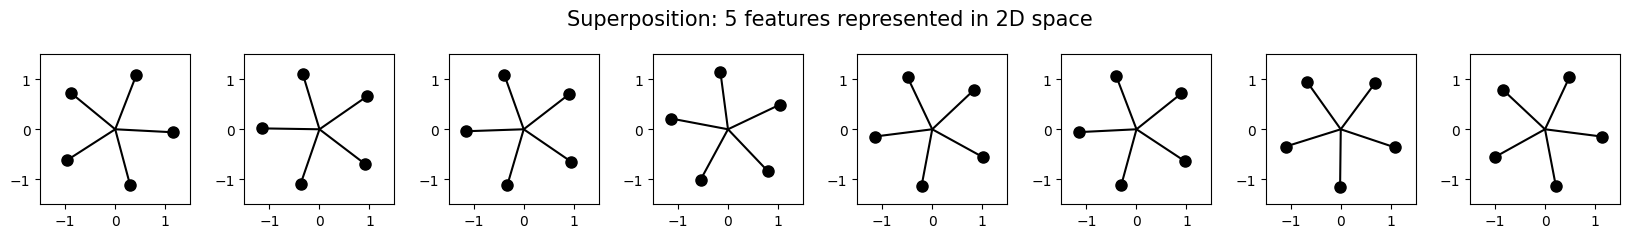

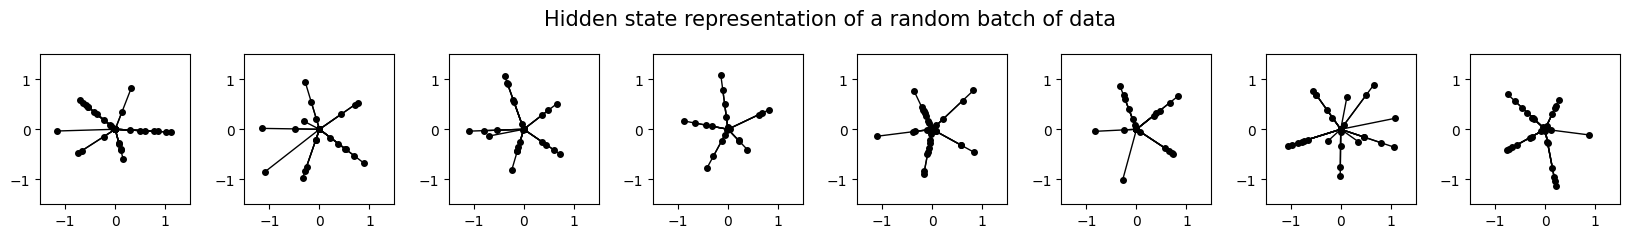

In [ ]:
# Verify we get the pentagon pattern we expect, for all instances:
plot_features_in_2d(
      W = model_c1.W.detach(),
      title = "Superposition: 5 features represented in 2D space",
)

# Generate a random batch, and verify that the embeddings more or less line up with what we expect:
batch_c1 = model_c1.generate_batch(200)
with t.inference_mode():
    hidden_c1 = einops.einsum(
        batch_c1, model_c1.W, "batch_size instances features, instances hidden features -> instances hidden batch_size"
    )
plot_features_in_2d(
    W = hidden_c1,
    title = "Hidden state representation of a random batch of data",
)

#### SAE (baseline)

In [ ]:
# Parameters
ae_cfg_c1 = AutoEncoderConfig(
    n_instances = 8,
    n_input_ae = 2,
    n_hidden_ae = 5,
    l1_coeff = 0.5,
)

# Model
autoencoder_c1 = AutoEncoder(ae_cfg_c1)
data_log_c1 = autoencoder_c1.optimize(
    model = model_c1,
    steps = 36_000,
    neuron_resample_window = 3_000,
    dead_neuron_window = 400,
    neuron_resample_scale = 0.5,
    log_freq = 400,
)

  0%|          | 0/36000 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/matplotlib/animation.py:884: UserWarning:

Animation was deleted without rendering anything. This is most likely not intended. To prevent deletion, assign the Animation to a variable, e.g. `anim`, that exists until you output the Animation using `plt.show()` or `anim.save()`.



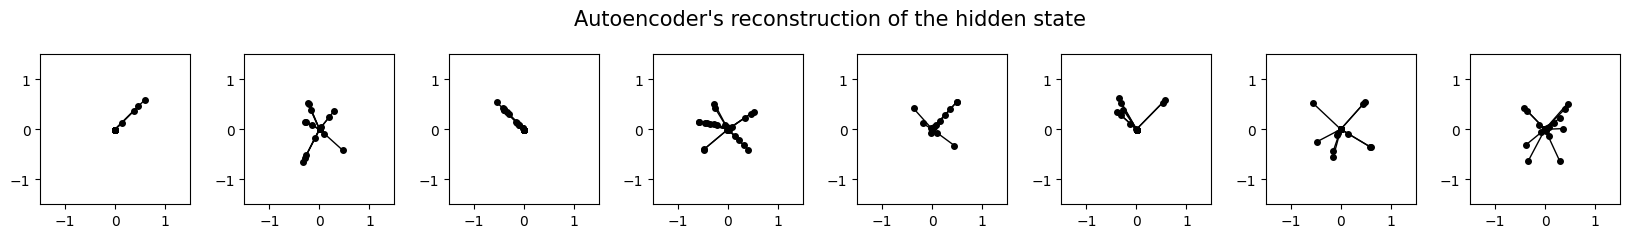

In [ ]:
# check disentangling performance
plot_features_in_2d(
    W = t.stack(data_log_c1["values"], dim=0),
    colors = data_log_c1["colors"],
    title = data_log_c1["titles"],
    colab = True,
)

# check dead neurons
frac_active_line_plot(
    frac_active = t.stack(data_log_c1["frac_active"], dim=0),
    feature_probability = 0.025,
    y_max = 0.1,
    title = "Probability of autoencoder neurons being active during training",
    width = 1000,
)

# check the points being reconstructed faithfully by our SAE
batch_c1 = model_c1.generate_batch(200)
hidden_c1 = einops.einsum(batch_c1, model_c1.W, "batch_size instances features, instances hidden features -> batch_size instances hidden")
hidden_reconstructed_c1 = autoencoder_c1.forward(hidden_c1)[-1]
plot_features_in_2d(
    W = einops.rearrange(hidden_reconstructed_c1, "batch_size instances hidden -> instances hidden batch_size"),  # hidden_c1
    title = "Autoencoder's reconstruction of the hidden state",
)

#### VAEs (**Proposed**)

1. Isotropic Gaussian prior

Equivalent to SAE if set `var_flag=0`. W try both cases here.

In [ ]:
# Parameters
vae_cfg_c1 = VariationalAutoEncoderConfig(
    n_instances = 8,
    n_input_ae = 2,
    n_hidden_ae = 5,
    kl_coeff = 0.5,
)

# Model (fixed variance)
vautoencoder_c1_fx = VariationalAutoEncoder(vae_cfg_c1, var_flag=0)
v_data_log_c1_fx = vautoencoder_c1_fx.optimize(
    model = model_c1,
    steps = 36_000,
    neuron_resample_window = 3_000,
    dead_neuron_window = 400,
    neuron_resample_scale = 0.5,
    log_freq = 400,
)

  0%|          | 0/36000 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/matplotlib/animation.py:884: UserWarning: Animation was deleted without rendering anything. This is most likely not intended. To prevent deletion, assign the Animation to a variable, e.g. `anim`, that exists until you output the Animation using `plt.show()` or `anim.save()`.
  warnings.warn(


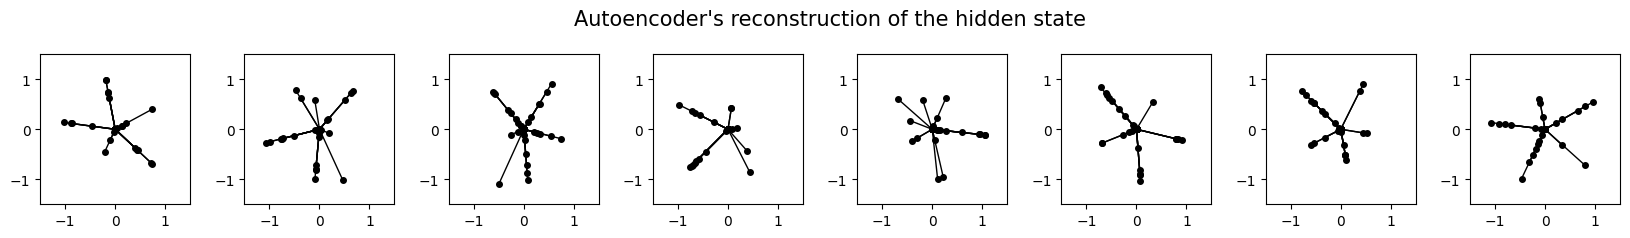

In [ ]:
# 1) VAE with fixed variance (equivalent to SAE, kl_coff=0.005)
# check disentangling performance
plot_features_in_2d(
    W = t.stack(v_data_log_c1_fx["values"], dim=0),
    colors = v_data_log_c1_fx["colors"],
    title = v_data_log_c1_fx["titles"],
    colab = True,
)

# check dead neurons
frac_active_line_plot(
    frac_active = t.stack(v_data_log_c1_fx["frac_active"], dim=0),
    feature_probability = 0.025,
    y_max = 0.1,
    title = "Probability of autoencoder neurons being active during training",
    width = 1000,
)

# check the points being reconstructed faithfully by our SAE
batch_c1 = model_c1.generate_batch(200)
hidden_c1 = einops.einsum(batch_c1, model_c1.W, "batch_size instances features, instances hidden features -> batch_size instances hidden")
hidden_reconstructed_c1_fx = vautoencoder_c1_fx.forward(hidden_c1)[-1]
plot_features_in_2d(
    W = einops.rearrange(hidden_reconstructed_c1_fx, "batch_size instances hidden -> instances hidden batch_size"),  # hidden_c1
    title = "Autoencoder's reconstruction of the hidden state",
)

We believe VAE has a better performance here, doesn't it?

2. Guassian mixture prior (Skip this time)

Tackle the setwise correlations.

3. Multivariable Gaussian prior (Skip this time)

Tackle general correlations.

### 2.2 Case 2: Varying sparsity



#### Toy model

In [ ]:
# Parameters
cfg_c2 = Config(
    n_instances = 8,
    n_features = 5,
    n_hidden = 2,
)

# Model
# 1) importance varies within features for each instance
importance = (0.9 ** t.arange(cfg_c2.n_features))
importance = einops.rearrange(importance, "features -> () features")

# 2) sparsity is the same for all features in a given instance, but varies over instances
feature_probability = (50 ** -t.linspace(0, 1, cfg_c2.n_instances))
feature_probability = einops.rearrange(feature_probability, "instances -> instances ()")

line(importance.squeeze(), width=600, height=400, title="Importance of each feature (same across instances)")
line(feature_probability.squeeze(), width=600, height=400, title="Feature probability (vary across instances)")

model_c2 = Model(
    cfg = cfg_c2,
    device = device,
    importance = importance,
    feature_probability = feature_probability,
)
model_c2.optimize(steps=10_000)

  0%|          | 0/10000 [00:00<?, ?it/s]

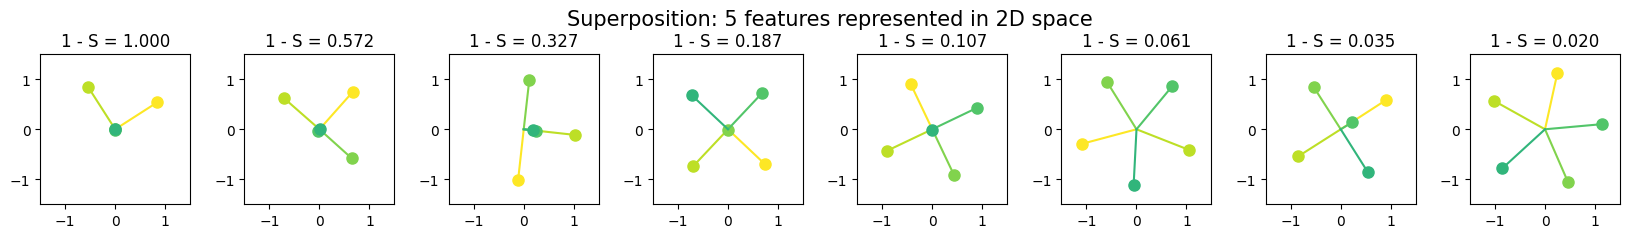

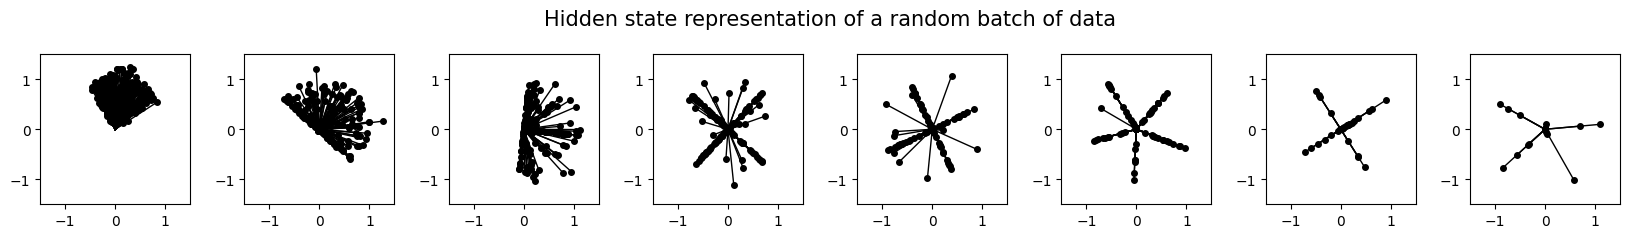

In [ ]:
# Verify we get the pentagon pattern we expect, for all instances:
plot_features_in_2d(
      W = model_c2.W.detach(),
      colors = model_c2.importance,
      title = "Superposition: 5 features represented in 2D space",
      subplot_titles = [f"1 - S = {i:.3f}" for i in feature_probability.squeeze()],
)

# Generate a random batch, and verify that the embeddings more or less line up with what we expect:
batch_c2 = model_c2.generate_batch(200)
with t.inference_mode():
    hidden_c2 = einops.einsum(
        batch_c2, model_c2.W, "batch_size instances features, instances hidden features -> instances hidden batch_size"
    )

plot_features_in_2d(
    W = hidden_c2,
    title = "Hidden state representation of a random batch of data",
)

#### SAE (baseline)

In [ ]:
# Parameters
ae_cfg_c2 = AutoEncoderConfig(
    n_instances = 8,
    n_input_ae = 2,
    n_hidden_ae = 5,
    l1_coeff = 0.5,
)

# Model
autoencoder_c2 = AutoEncoder(ae_cfg_c2)
data_log_c2 = autoencoder_c2.optimize(
    model = model_c2,
    steps = 36_000,
    neuron_resample_window = 3_000,
    dead_neuron_window = 400,
    neuron_resample_scale = 0.5,
    log_freq = 400,
)

  0%|          | 0/36000 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/matplotlib/animation.py:884: UserWarning:

Animation was deleted without rendering anything. This is most likely not intended. To prevent deletion, assign the Animation to a variable, e.g. `anim`, that exists until you output the Animation using `plt.show()` or `anim.save()`.



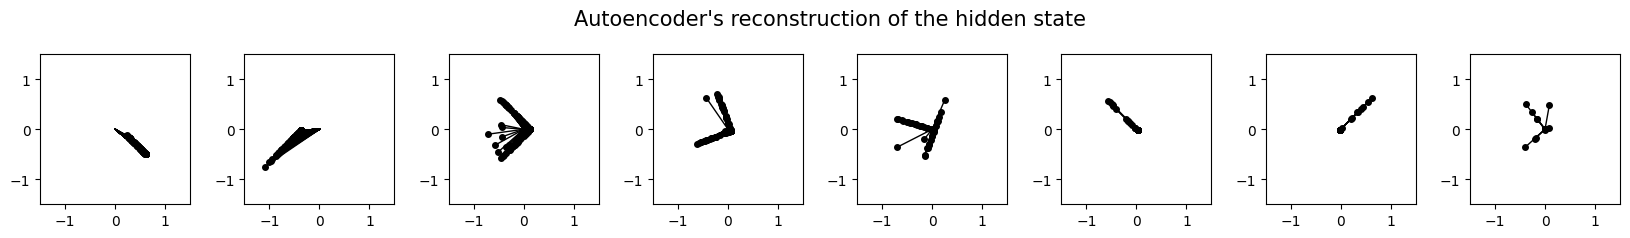

In [ ]:
# check disentangling performance
plot_features_in_2d(
    W = t.stack(data_log_c2["values"], dim=0),
    colors = data_log_c2["colors"],
    title = data_log_c2["titles"],
    colab = True,
)

# check the points being reconstructed faithfully by our SAE
batch_c2 = model_c2.generate_batch(200)
hidden_c2 = einops.einsum(batch_c2, model_c2.W, "batch_size instances features, instances hidden features -> batch_size instances hidden")
hidden_reconstructed_c2 = autoencoder_c2.forward(hidden_c2)[-1]
plot_features_in_2d(
    W = einops.rearrange(hidden_reconstructed_c2, "batch_size instances hidden -> instances hidden batch_size"),  # hidden_c1
    title = "Autoencoder's reconstruction of the hidden state",
)

We can see that the SAE doesn't work that well for the case with varying importance and sparsity.

#### VAEs (proposed)

1. Isotropic Gaussian prior

Equivalent to SAE if set `var_flag=0`.

In [ ]:
# Parameters
vae_cfg_c2 = VariationalAutoEncoderConfig(
    n_instances = 8,
    n_input_ae = 2,
    n_hidden_ae = 5,
    kl_coeff = 0.5,
)

# Model (fixed variance)
vautoencoder_c2_fx = VariationalAutoEncoder(vae_cfg_c2)
v_data_log_c2_fx = vautoencoder_c2_fx.optimize(
    model = model_c2,
    steps = 36_000,
    neuron_resample_window = 3_000,
    dead_neuron_window = 400,
    neuron_resample_scale = 0.5,
    log_freq = 400,
)

  0%|          | 0/36000 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/matplotlib/animation.py:884: UserWarning:

Animation was deleted without rendering anything. This is most likely not intended. To prevent deletion, assign the Animation to a variable, e.g. `anim`, that exists until you output the Animation using `plt.show()` or `anim.save()`.



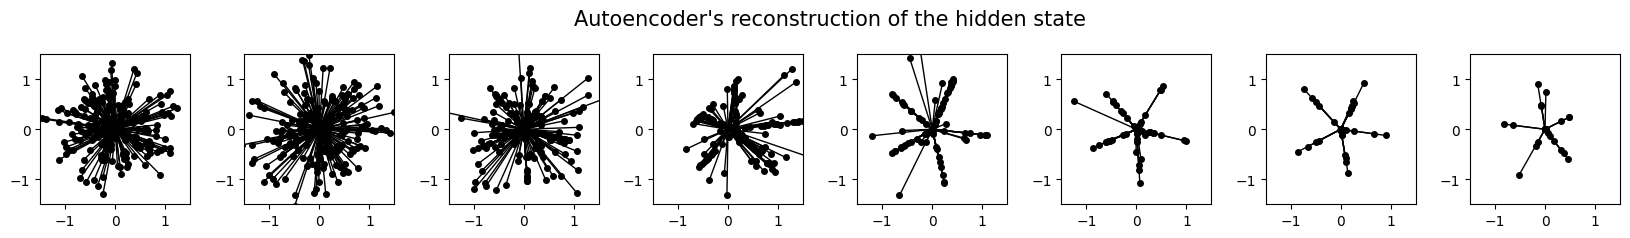

In [ ]:
# 1) VAE with fixed variance (equivalent to SAE)
# check disentangling performance
plot_features_in_2d(
    W = t.stack(v_data_log_c2_fx["values"], dim=0),
    colors = v_data_log_c2_fx["colors"],
    title = v_data_log_c2_fx["titles"],
    colab = True,
)

# check the points being reconstructed faithfully by our SAE
batch_c2 = model_c2.generate_batch(200)
hidden_c2 = einops.einsum(batch_c2, model_c1.W, "batch_size instances features, instances hidden features -> batch_size instances hidden")
hidden_reconstructed_c2_fx = vautoencoder_c2_fx.forward(hidden_c2)[-1]
plot_features_in_2d(
    W = einops.rearrange(hidden_reconstructed_c2_fx, "batch_size instances hidden -> instances hidden batch_size"),  # hidden_c1
    title = "Autoencoder's reconstruction of the hidden state",
)

We can see there are varying numbers of clusters for the reconstructed lines.

2. Guassian mixture prior  (Skip this time)

Tackle the setwise correlations.

3. Multivariable Gaussian prior (Skip this time)

Tackle general correlations.

### 2.4 Case 4: With anti-correlated pairs

#### Toy model

In [ ]:
# Parameters
cfg_c4 = Config(
    n_instances = 8,
    n_features = 4,
    n_hidden = 2,
    n_correlated_pairs = 0,
    n_anticorrelated_pairs = 2,
)

# Model
# All same importance, very low feature probabilities (ranging from 5% down to 0.25%)
importance = t.ones(cfg_c4.n_features, dtype=t.float, device=device)
importance = einops.rearrange(importance, "features -> () features")
feature_probability = (10 ** -t.linspace(0.5, 1, cfg_c4.n_instances))
feature_probability = einops.rearrange(feature_probability, "instances -> instances ()")

model_c4 = Model(
    cfg = cfg_c4,
    device = device,
    importance = importance,
    feature_probability = feature_probability,
)
model_c4.optimize()

  0%|          | 0/10000 [00:00<?, ?it/s]

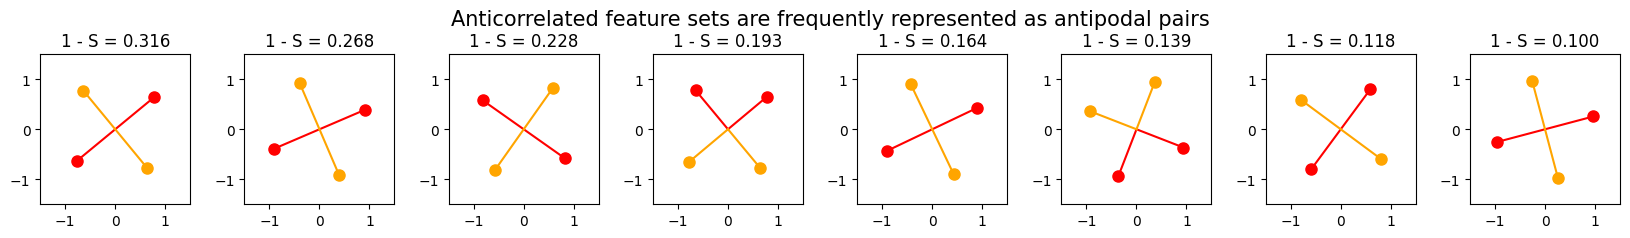

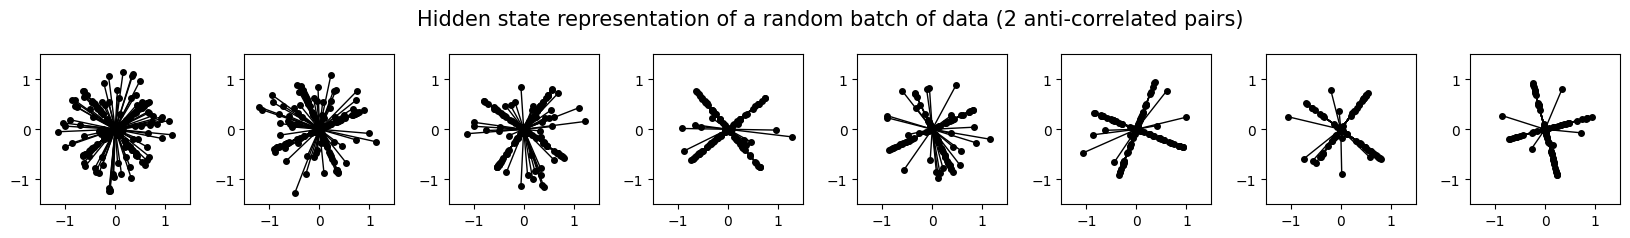

In [ ]:
# Verify we get the pentagon as expected
plot_features_in_2d(
    W = model_c4.W.detach(),
    colors = ["red"] * 2 + ["orange"] * 2,  # We plot each anticorrelated feature pair with the same color
    title = "Anticorrelated feature sets are frequently represented as antipodal pairs",
    subplot_titles = [f"1 - S = {i:.3f}" for i in model_c4.feature_probability[:, 0]],
)

# Generate a random batch and verify the embedding lined up
batch_c4 = model_c4.generate_batch(batch_size=200)
with t.inference_mode():
    hidden_c4 = einops.einsum(
        batch_c4, model_c4.W, "batch_size instances features, instances hidden features -> instances hidden batch_size"
)
plot_features_in_2d(
    W = hidden_c4,
    title = "Hidden state representation of a random batch of data (2 anti-correlated pairs)",
)

#### SAE (baseline)

In [ ]:
# Parameters
# cfg_c4 = Config(
#    n_instances = 8,
#    n_features = 4,
#    n_hidden = 2,
#    n_correlated_pairs = 0,
#    n_anticorrelated_pairs = 2,
# )
ae_cfg_c4 = AutoEncoderConfig(
    n_instances = 8,
    n_input_ae = 2,
    n_hidden_ae = 4,
    l1_coeff = 0.5,
)

# Model
autoencoder_c4 = AutoEncoder(ae_cfg_c4)
data_log_c4 = autoencoder_c4.optimize(
    model = model_c4,
    steps = 36_000,
    neuron_resample_window = 3_000,
    dead_neuron_window = 400,
    neuron_resample_scale = 0.5,
    log_freq = 400,
)

  0%|          | 0/36000 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/matplotlib/animation.py:884: UserWarning:

Animation was deleted without rendering anything. This is most likely not intended. To prevent deletion, assign the Animation to a variable, e.g. `anim`, that exists until you output the Animation using `plt.show()` or `anim.save()`.



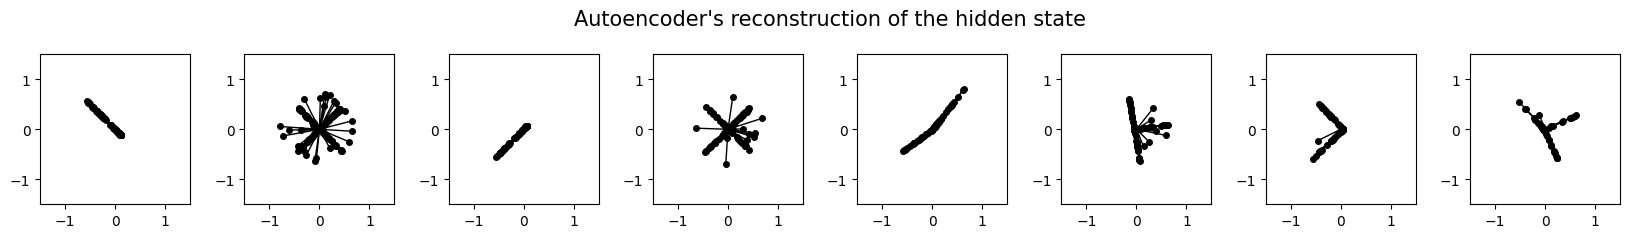

In [ ]:
# check disentangling performance
plot_features_in_2d(
    W = t.stack(data_log_c4["values"], dim=0),
    colors = data_log_c4["colors"],
    title = data_log_c4["titles"],
    colab = True,
)

# check the points being reconstructed faithfully by our SAE
batch_c4 = model_c4.generate_batch(200)
hidden_c4 = einops.einsum(batch_c4, model_c4.W, "batch_size instances features, instances hidden features -> batch_size instances hidden")
hidden_reconstructed_c4 = autoencoder_c4.forward(hidden_c4)[-1]
plot_features_in_2d(
    W = einops.rearrange(hidden_reconstructed_c4, "batch_size instances hidden -> instances hidden batch_size"),  # hidden_c1
    title = "Autoencoder's reconstruction of the hidden state",
)

#### VAEs (proposed)

1. Isotropic Gaussian prior (Skip this time)

Equivalent to SAE if set `var_flag=0`.

2. Guassian mixture prior

Tackle the setwise correlations.

In [ ]:
# Parameters
# cfg_c4 = Config(
#    n_instances = 8,
#    n_features = 4,
#    n_hidden = 2,
#    n_correlated_pairs = 0,
#    n_anticorrelated_pairs = 2,
# )
vae_cfg_c4 = MixVariationalAutoEncoderConfig(
    n_instances = 8,
    n_input_ae = 2,
    n_hidden_ae = 4,
    kl_coeff = 0.5,
    n_correlated_pairs = 0,
    n_anticorrelated_pairs = 2,
)

# Model
vautoencoder_c4 = MixVariationalAutoEncoder(vae_cfg_c4, var_flag=0)  # var_flag=1
v_data_log_c4 = vautoencoder_c4.optimize(
    model = model_c4,
    steps = 36_000,
    neuron_resample_window = 3_000,
    dead_neuron_window = 400,
    neuron_resample_scale = 0.5,
    log_freq = 400,
)

  0%|          | 0/36000 [00:00<?, ?it/s]

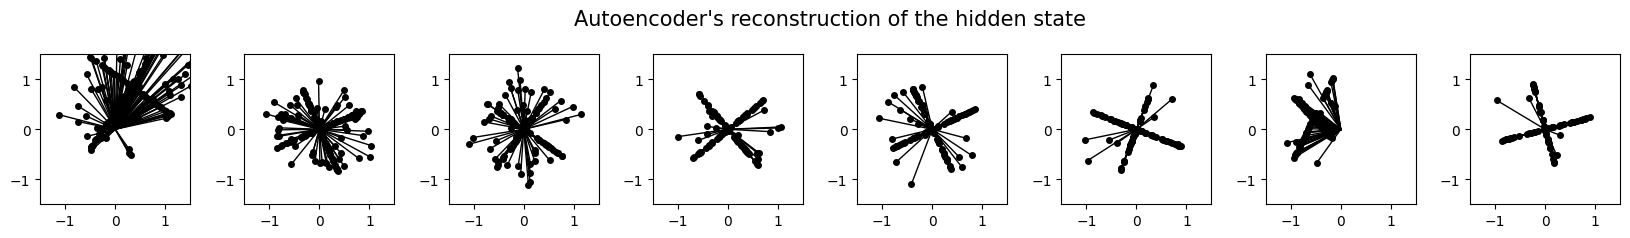

In [ ]:
# check disentangling performance
plot_features_in_2d(
    W = t.stack(v_data_log_c4["values"], dim=0),
    colors = v_data_log_c4["colors"],
    title = v_data_log_c4["titles"],
    colab = True,
)

# check the points being reconstructed faithfully by our SAE
batch_c4 = model_c4.generate_batch(200)
hidden_c4 = einops.einsum(batch_c4, model_c4.W, "batch_size instances features, instances hidden features -> batch_size instances hidden")
hidden_reconstructed_c4 = vautoencoder_c4.forward(hidden_c4)[-1]
plot_features_in_2d(
    W = einops.rearrange(hidden_reconstructed_c4, "batch_size instances hidden -> instances hidden batch_size"),  # hidden_c1
    title = "Autoencoder's reconstruction of the hidden state",
)

3. Multivariable Gaussian prior (Skip this time)

Tackle general correlations.

### 2.5 Case 5: With correlated and anti-correlated pairs

#### Toy model

In [ ]:
# Parameters
cfg_c5 = Config(
    n_instances = 8,
    n_features = 4,
    n_hidden = 2,
    n_correlated_pairs = 1,
    n_anticorrelated_pairs = 1,
)

# Model
# All same importance, very low feature probabilities (ranging from 5% down to 0.25%)
importance = t.ones(cfg_c5.n_features, dtype=t.float, device=device)
importance = einops.rearrange(importance, "features -> () features")
feature_probability = (10 ** -t.linspace(0.5, 1, cfg_c5.n_instances))
feature_probability = einops.rearrange(feature_probability, "instances -> instances ()")

model_c5 = Model(
    cfg = cfg_c5,
    device = device,
    importance = importance,
    feature_probability = feature_probability,
)
model_c5.optimize()

  0%|          | 0/10000 [00:00<?, ?it/s]

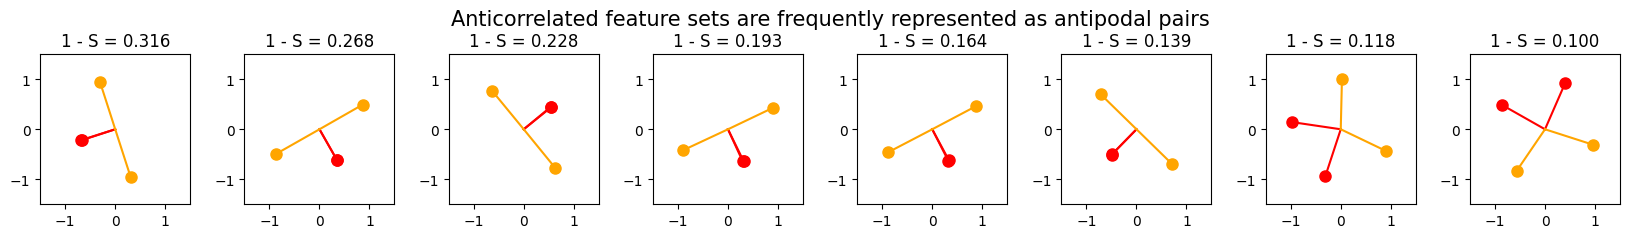

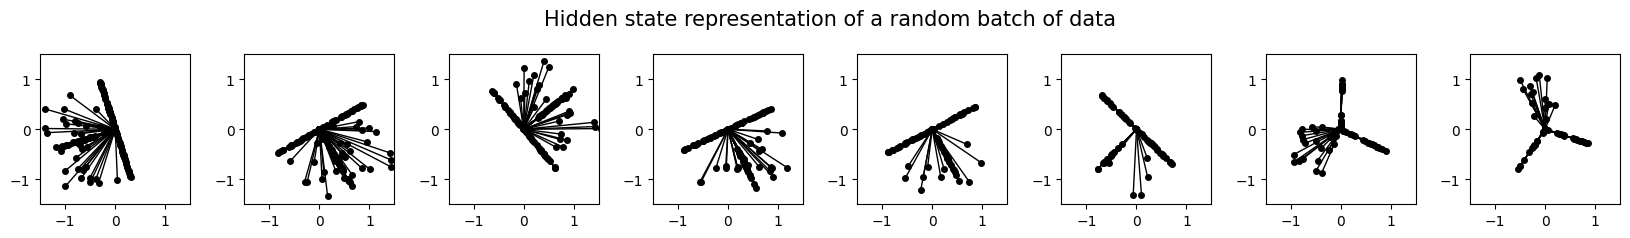

In [ ]:
# Verify we get the pentagon pattern as expected
plot_features_in_2d(
    W = model_c5.W.detach(),
    colors = ["red"] * 2 + ["orange"] * 2,  # We plot each anticorrelated feature pair with the same color
    title = "Anticorrelated feature sets are frequently represented as antipodal pairs",
    subplot_titles = [f"1 - S = {i:.3f}" for i in model_c5.feature_probability[:, 0]],
)

# Generate a batch of 4 features: first 2 are correlated, second 2 are anticorrelated
batch_c5 = model_c5.generate_batch(batch_size=200)
correlated_feature_batch, anticorrelated_feature_batch = batch_c5[:, :, :2], batch_c5[:, :, 2:]

# # Plot correlated features
# plot_correlated_features(correlated_feature_batch, title="Correlated Features: should always co-occur")
# plot_correlated_features(anticorrelated_feature_batch, title="Anti-correlated Features: should never co-occur")

with t.inference_mode():
    hidden_c5 = einops.einsum(
        batch_c5, model_c5.W, "batch_size instances features, instances hidden features -> instances hidden batch_size"
)
plot_features_in_2d(
    W = hidden_c5,
    title = "Hidden state representation of a random batch of data",
)

#### SAE (baseline)

In [ ]:
# Parameters
# cfg_c5 = Config(
#    n_instances = 8,
#    n_features = 4,
#    n_hidden = 2,
#    n_correlated_pairs = 1,
#    n_anticorrelated_pairs = 1,
# )
ae_cfg_c5 = AutoEncoderConfig(
    n_instances = 8,
    n_input_ae = 2,
    n_hidden_ae = 4,
    l1_coeff = 0.5,
)

# Model
autoencoder_c5 = AutoEncoder(ae_cfg_c5)
data_log_c5 = autoencoder_c5.optimize(
    model = model_c5,
    steps = 36_000,
    neuron_resample_window = 3_000,
    dead_neuron_window = 400,
    neuron_resample_scale = 0.5,
    log_freq = 400,
)

  0%|          | 0/36000 [00:00<?, ?it/s]

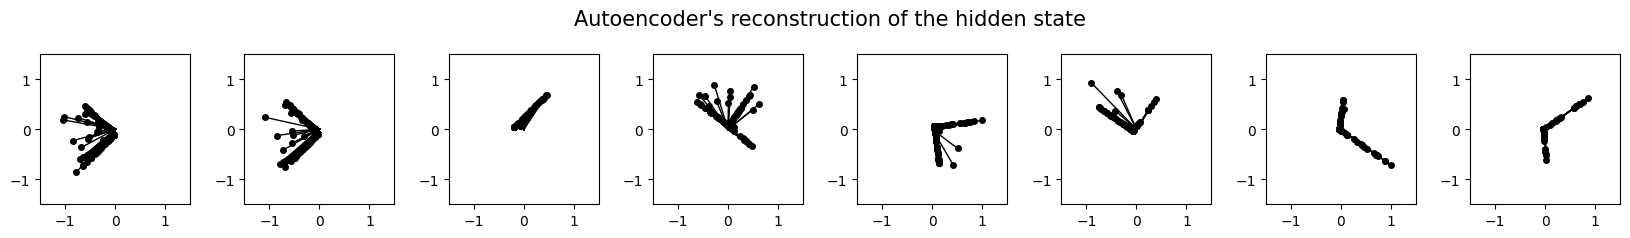

In [ ]:
# check disentangling performance
plot_features_in_2d(
    W = t.stack(data_log_c5["values"], dim=0),
    colors = data_log_c5["colors"],
    title = data_log_c5["titles"],
    colab = True,
)
# check the points being reconstructed faithfully by our SAE
batch_c5 = model_c5.generate_batch(200)
hidden_c5 = einops.einsum(batch_c5, model_c5.W, "batch_size instances features, instances hidden features -> batch_size instances hidden")
hidden_reconstructed_c5 = autoencoder_c5.forward(hidden_c5)[-1]
plot_features_in_2d(
    W = einops.rearrange(hidden_reconstructed_c5, "batch_size instances hidden -> instances hidden batch_size"),  # hidden_c1
    title = "Autoencoder's reconstruction of the hidden state",
)

#### VAEs (proposed)

1. Isotropic Gaussian prior (Skip this time)

Equivalent to SAE if set `var_flag=0`.

2. Guassian mixture prior

Tackle the setwise correlations.

In [ ]:
# Parameters
# cfg_c5 = Config(
#    n_instances = 8,
#    n_features = 4,
#    n_hidden = 2,
#    n_correlated_pairs = 1,
#    n_anticorrelated_pairs = 1,
# )
vae_cfg_c5 = MixVariationalAutoEncoderConfig(
    n_instances = 8,
    n_input_ae = 2,
    n_hidden_ae = 4,
    kl_coeff = 0.5,
    n_correlated_pairs = 1,
    n_anticorrelated_pairs = 1,
)

# Model
vautoencoder_c5 = MixVariationalAutoEncoder(vae_cfg_c5, var_flag=0)  # var_flag=1
v_data_log_c5 = vautoencoder_c5.optimize(
    model = model_c5,
    steps = 36_000,
    neuron_resample_window = 3_000,
    dead_neuron_window = 400,
    neuron_resample_scale = 0.5,
    log_freq = 400,
)

  0%|          | 0/36000 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/matplotlib/animation.py:884: UserWarning:

Animation was deleted without rendering anything. This is most likely not intended. To prevent deletion, assign the Animation to a variable, e.g. `anim`, that exists until you output the Animation using `plt.show()` or `anim.save()`.



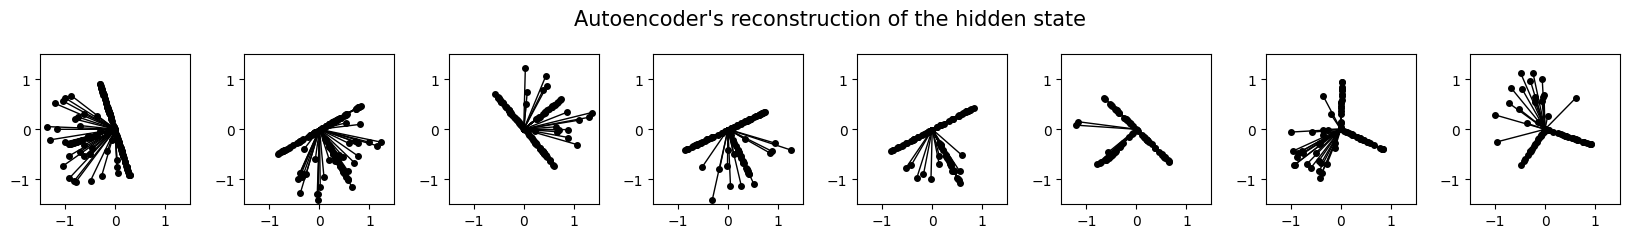

In [ ]:
# check disentangling performance
plot_features_in_2d(
    W = t.stack(v_data_log_c5["values"], dim=0),
    colors = v_data_log_c5["colors"],
    title = v_data_log_c5["titles"],
    colab = True,
)

# check the points being reconstructed faithfully by our SAE
batch_c5 = model_c5.generate_batch(200)
hidden_c5 = einops.einsum(batch_c5, model_c5.W, "batch_size instances features, instances hidden features -> batch_size instances hidden")
hidden_reconstructed_c5 = vautoencoder_c5.forward(hidden_c5)[-1]
plot_features_in_2d(
    W = einops.rearrange(hidden_reconstructed_c5, "batch_size instances hidden -> instances hidden batch_size"),  # hidden_c1
    title = "Autoencoder's reconstruction of the hidden state",
)

It's clearly much better in revealing structures!

3. Multivariable Gaussian prior (Skip this time)

Tackle general correlations.

### 2.6 Case 6: With correlation matrix

#### Toy model

We're using a different toy model here!

In [ ]:
# Parameters
cfg_c6 = ConfigCorr(
    n_instances = 8,
    n_features = 4,
    n_hidden = 2,
    corr_rate = 0.5,  # can also implement a correlation matrix for advanced cases
)

# Model
# All same importance, very low feature probabilities (ranging from 5% down to 0.25%)
importance = t.ones(cfg_c6.n_features, dtype=t.float, device=device)
importance = einops.rearrange(importance, "features -> () features")
feature_probability = (10 ** -t.linspace(0.5, 1, cfg_c6.n_instances))
feature_probability = einops.rearrange(feature_probability, "instances -> instances ()")

model_c6 = ModelCorr(
    cfg = cfg_c6,
    device = device,
    importance = importance,
    feature_probability = feature_probability,
)
model_c6.optimize()

  0%|          | 0/10000 [00:00<?, ?it/s]

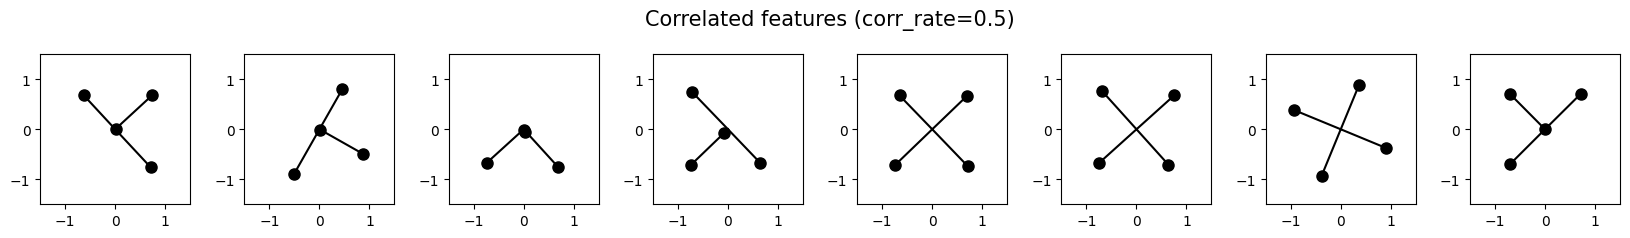

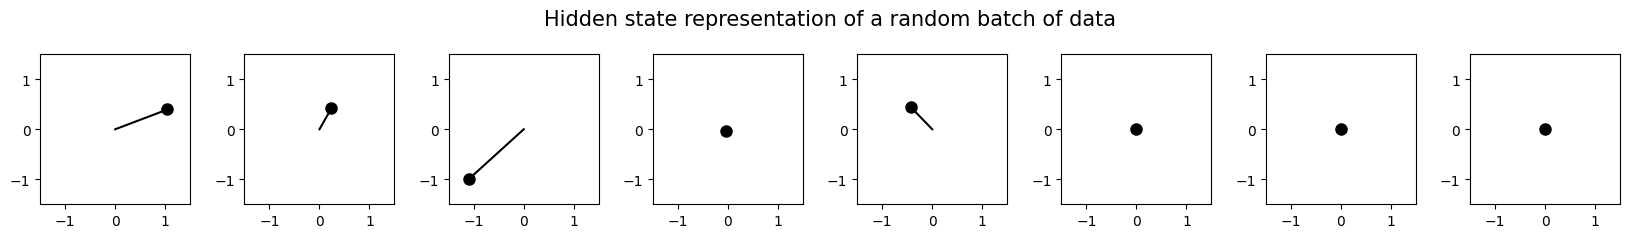

In [ ]:
# Verify we get the pentagon pattern as expected
plot_features_in_2d(
    W = model_c6.W.detach(),
    title = "Correlated features (corr_rate=0.5)",
)

# Generate a batch of 4 features: first 2 are correlated, second 2 are anticorrelated
batch_c6 = model_c6.generate_batch(batch_size = 200)
with t.inference_mode():
    hidden_c6 = einops.einsum(
        batch_c6, model_c6.W, "batch_size instances features, instances hidden features -> instances hidden batch_size"
)
plot_features_in_2d(
    W = hidden_c6,
    title = "Hidden state representation of a random batch of data",
)

#### SAE (baseline)

In [ ]:
# Parameters
# cfg_c6 = ConfigCorr(
#    n_instances = 8,
#    n_features = 4,
#    n_hidden = 2,
#    corr_rate = 0.5,
# )
ae_cfg_c6 = AutoEncoderConfig(
    n_instances = 8,
    n_input_ae = 2,
    n_hidden_ae = 4,
    l1_coeff = 0.5,
)

# Model
autoencoder_c6 = AutoEncoder(ae_cfg_c6)
data_log_c6 = autoencoder_c6.optimize(
    model = model_c6,
    steps = 36_000,
    neuron_resample_window = 3_000,
    dead_neuron_window = 400,
    neuron_resample_scale = 0.5,
    log_freq = 400,
)

  0%|          | 0/36000 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/matplotlib/animation.py:884: UserWarning:

Animation was deleted without rendering anything. This is most likely not intended. To prevent deletion, assign the Animation to a variable, e.g. `anim`, that exists until you output the Animation using `plt.show()` or `anim.save()`.



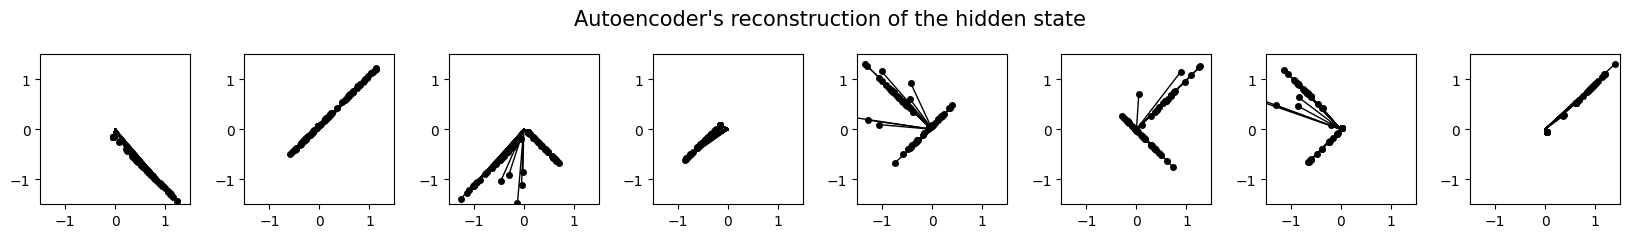

In [ ]:
# check disentangling performance
plot_features_in_2d(
    W = t.stack(data_log_c6["values"], dim=0),
    colors = data_log_c6["colors"],
    title = data_log_c6["titles"],
    colab = True,
)

# check the points being reconstructed faithfully by our SAE
batch_c6 = model_c6.generate_batch(200)
hidden_c6 = einops.einsum(batch_c6, model_c6.W, "batch_size instances features, instances hidden features -> batch_size instances hidden")
hidden_reconstructed_c6 = autoencoder_c6.forward(hidden_c6)[-1]
plot_features_in_2d(
    W = einops.rearrange(hidden_reconstructed_c6, "batch_size instances hidden -> instances hidden batch_size"),  # hidden_c1
    title = "Autoencoder's reconstruction of the hidden state",
)

#### VAEs (proposed)

1. Isotropic Gaussian prior (Skip this time)

Equivalent to SAE if set `var_flag=0`.

2. Guassian mixture prior (Skip this time)

Tackle the setwise correlations.

3. Multivariable Gaussian prior

Tackle general correlations.

In [ ]:
# Parameters
# cfg_c6 = ConfigCorr(
#    n_instances = 8,
#    n_features = 4,
#    n_hidden = 2,
#    corr_rate = 0.5,
# )
vae_cfg_c6 = GeneralVariationalAutoEncoderConfig(
    n_instances = 8,
    n_input_ae = 2,
    n_hidden_ae = 4,
    kl_coeff = 10,
    corr_rate = 0.5,
)

# Model
vautoencoder_c6 = GeneralVariationalAutoEncoder(vae_cfg_c6, var_flag=0)  # var_flag=1
v_data_log_c6 = vautoencoder_c6.optimize(
    model = model_c6,
    steps = 36_000,
    neuron_resample_window = 3_000,
    dead_neuron_window = 400,
    neuron_resample_scale = 0.5,
    log_freq = 400,
)

  0%|          | 0/36000 [00:00<?, ?it/s]

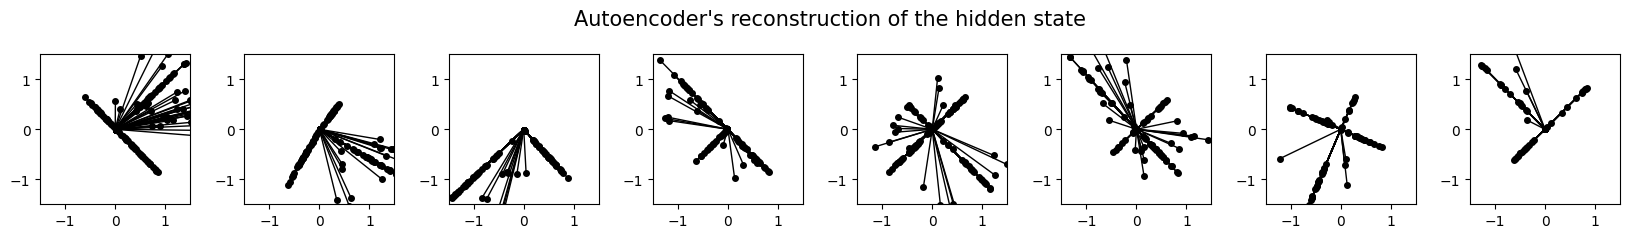

In [ ]:
# check disentangling performance
plot_features_in_2d(
    W = t.stack(v_data_log_c6["values"], dim=0),
    colors = v_data_log_c6["colors"],
    title = v_data_log_c6["titles"],
    colab = True,
)

# check the points being reconstructed faithfully by our SAE
batch_c6 = model_c6.generate_batch(200)
hidden_c6 = einops.einsum(batch_c6, model_c6.W, "batch_size instances features, instances hidden features -> batch_size instances hidden")
hidden_reconstructed_c6 = vautoencoder_c6.forward(hidden_c6)[-1]
plot_features_in_2d(
    W = einops.rearrange(hidden_reconstructed_c6, "batch_size instances hidden -> instances hidden batch_size"),  # hidden_c1
    title = "Autoencoder's reconstruction of the hidden state",
)

It's clearly much better in revealing structures!